**Universidad Internacional de La Rioja (UNIR) - Máster Universitario en Inteligencia Artificial - Redes Neuronales y Aprendizaje Profundo**

***
Datos del alumno (Nombre y Apellidos): Jose Manuel Pinillos Rubio

Fecha: 7 de junio de 2025
***

# <span style="font-size: 20pt; font-weight: bold; color: #0098cd;">Redes Neuronales Recurrentes (RNN)</span>

En esta actividad grupal, vamos a utilizar las RNN para identificar la intensidad de odio en mensajes escritos en las redes sociales.

Por sencillez, se adjunta un documento csv que es una versión resumida del *dataset* original del proyecto transversal. En este *dataset*, solo se incluyen los mensajes que han sido catalogados como contenedores de odio. También se han eliminado las features innecesarias para este trabajo simplemente para hacer todo el proceso más rápido computacionalmente hablando.

El *dataset* a utilizar consiste en 12280 mensajes de odio. Los mensajes pueden pertenecer a cinco categorias (numeradadas del 1 al 5), siendo 1 la menor intensidadd y 5 la mayor intensidad de odio del mensaje. El dataset ya ha sido procesado para eliminar ciertos caracteres que podrían darte problemas y para utilizar una codificación más amigable.

## 1. Análisis exploratorio de los datos

### 1.1 - Importación de librerías

In [ ]:
# -------------------- Utilidades generales --------------------
import os                                  # Operaciones del sistema
import random                              # Semilla aleatoria
import numpy as np                         # Operaciones numéricas
import pandas as pd                        # Manipulación de datos
import string                              # Manejo de caracteres
import re                                  # Expresiones regulares

# -------------------- Visualización --------------------
import matplotlib.pyplot as plt            # Gráficos base
import seaborn as sns                      # Visualización avanzada (mapas de calor, estilo)

# -------------------- Preprocesamiento NLP --------------------
import nltk                                # Biblioteca de procesamiento del lenguaje
nltk.download('stopwords')                 # Descarga de stopwords
nltk.download('wordnet')                   # Descarga del lematizador WordNet
from nltk.stem import WordNetLemmatizer    # Lematización
from nltk.corpus import stopwords          # Lista de palabras vacías

# -------------------- Preparación de datos --------------------
from sklearn.model_selection import train_test_split                     # División de datos
from sklearn.utils import class_weight                                   # Cálculo de pesos de clase
from sklearn.preprocessing import label_binarize                         # Binarización de etiquetas
from sklearn.feature_extraction.text import TfidfVectorizer              # Vectorización TF-IDF

# -------------------- Métricas y evaluación --------------------
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, roc_curve, auc
)

# -------------------- Modelado clásico (para ROC) --------------------
from sklearn.multiclass import OneVsRestClassifier                       # Clasificación multiclase OvR
from sklearn.linear_model import LogisticRegression                      # Modelo base para OvR
from sklearn.pipeline import make_pipeline                               # Pipeline para ROC

# -------------------- Redes neuronales (TensorFlow / Keras) --------------------
import tensorflow as tf                    # Framework de aprendizaje profundo
from tensorflow import keras               # API de alto nivel
from tensorflow.keras import layers        # Capas de red neuronal
from tensorflow.keras import regularizers  # Regularización L1/L2
from tensorflow.keras.preprocessing.text import Tokenizer                # Tokenización de texto
from tensorflow.keras.preprocessing.sequence import pad_sequences        # Relleno de secuencias

# -------------------- Semillas para reproducibilidad --------------------
seed_value = 13
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)             # Semilla para TensorFlow

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


### 1.2 - Carga de los datos

In [ ]:
# Importamos el dataset con separador ";"
data = pd.read_csv('dataset.csv', sep=";", encoding='utf-8')

# Mostramos las 5 primeras filas del dataset para verificar la carga de datos
data.head()

,CONTENIDO A ANALIZAR,INTENSIDAD
0,cristina cifuentes podrí­a haber sido la presi...,3
1,habrí­a que reabrir el caso. el supremo se ded...,3
2,me parece un poco exagerado pedir más de tres ...,3
3,parece que todos los delincuentes niegan las e...,3
4,"preguntárselo al fracasado, media carrera en 6...",4


### 1.3 - Renombrado de columnas

In [ ]:
# Renombramos las columnas para facilitar su uso posterior
# 'CONTENIDO A ANALIZAR' pasa a 'mensaje' y 'INTENSIDAD' a 'intensidad'
data = data.rename(columns={'CONTENIDO A ANALIZAR': 'mensaje', 'INTENSIDAD': 'intensidad'})

# Mostramos las primeras 5 filas del DataFrame para verificar los cambios
data.head()

,mensaje,intensidad
0,cristina cifuentes podrí­a haber sido la presi...,3
1,habrí­a que reabrir el caso. el supremo se ded...,3
2,me parece un poco exagerado pedir más de tres ...,3
3,parece que todos los delincuentes niegan las e...,3
4,"preguntárselo al fracasado, media carrera en 6...",4


### 1.4 - Dimensiones del conjunto de datos

In [ ]:
# Mostramos las dimensiones del DataFrame: número de filas y columnas
data.shape

(12279, 2)

El conjunto de datos está compuesto por un total de 12.279 registros distribuidos en dos columnas, lo que concuerda con la salida de `data.shape`.

### 1.5 - Información del `dataset`

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12279 entries, 0 to 12278
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   mensaje     12279 non-null  object
 1   intensidad  12279 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 192.0+ KB


Al examinar la estructura del DataFrame mediante `data.info()`, se observa que no existen valores nulos en ninguna de las columnas: tanto `mensaje` como `intensidad` contienen 12.279 observaciones completas. La variable `mensaje` está correctamente tipada como objeto, lo que en pandas corresponde a texto, mientras que `intensidad` aparece como un entero de 64 bits (`int64`), lo que confirma que se trata de una variable numérica discreta, en este caso, categórica ordinal.

### 1.6 - Distribución de clases

Mostramos ahora la distribución de mensajes de acuerdo a su intensidad. Verás rápidamente que estamos en problemas: hay un gran desbalanceo.

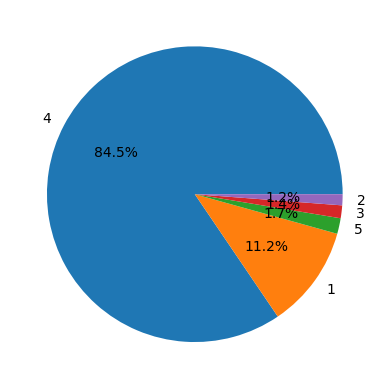

In [ ]:
# Representamos gráficamente la proporción de cada clase en la variable 'intensidad'
# Usamos un gráfico de sectores para mostrar la distribución porcentual

plt.pie(data['intensidad'].value_counts().values,          # Frecuencia de cada clase
        labels=data['intensidad'].value_counts().index,    # Etiquetas de clase (1 a 5)
        autopct='%1.1f%%')                                 # Formato de porcentaje con un decimal

# Mostramos el gráfico
plt.show()

El gráfico circular generado permite visualizar de forma general la distribución porcentual de las clases de intensidad. Se observa que la clase **4** domina claramente el conjunto de datos, representando el **84.5 %** de los mensajes. A continuación, la clase **1** aparece con un **11.2 %**, mientras que las clases **2**, **3** y **5** tienen una representación testimonial, con valores comprendidos entre el **1.2 % y el 1.7 %**.

No obstante, al tratarse de un gráfico de sectores, la lectura detallada y la comparación entre clases minoritarias resulta poco clara, especialmente debido a la gran desproporción existente. Por esta razón, se opta por complementar la visualización con un gráfico de barras, el cual permite apreciar con mayor nitidez las diferencias absolutas en el número de observaciones por clase.

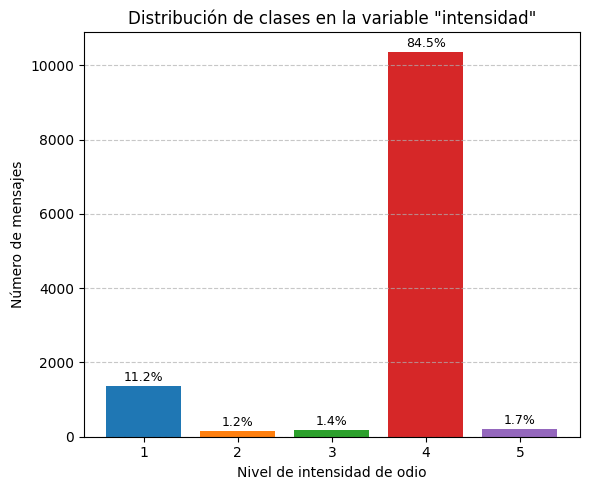

In [ ]:
# Obtenemos la frecuencia de cada clase de intensidad y las ordenamos por índice
conteo_clases = data['intensidad'].value_counts().sort_index()

# Número total de mensajes para calcular porcentajes
total_mensajes = len(data)

# Creamos el gráfico
plt.figure(figsize=(6, 5))  # Tamaño del gráfico

# Dibujamos cada barra individualmente para permitir el uso de colores automáticos
for i, (clase, frecuencia) in enumerate(conteo_clases.items()):
    plt.bar(clase, frecuencia)  # Matplotlib asigna el color automáticamente

    # Calculamos el porcentaje correspondiente a cada barra
    porcentaje = (frecuencia / total_mensajes) * 100

    # Añadimos el texto con el porcentaje sobre la barra
    plt.text(clase, frecuencia + 50,                  # Posición del texto (ligeramente por encima de la barra)
             f'{porcentaje:.1f}%',                    # Texto a mostrar: porcentaje con un decimal
             ha='center', va='bottom', fontsize=9)    # Alineación y tamaño de fuente

# Añadimos etiquetas y formato
plt.xlabel('Nivel de intensidad de odio')             # Etiqueta del eje x
plt.ylabel('Número de mensajes')                      # Etiqueta del eje y
plt.title('Distribución de clases en la variable "intensidad"')  # Título del gráfico
plt.xticks(conteo_clases.index)                       # Mostramos los niveles 1 a 5
plt.grid(axis='y', linestyle='--', alpha=0.7)         # Guías horizontales
plt.tight_layout()
plt.show()

El gráfico de barras confirma visualmente lo ya observado en el diagrama de sectores: la clase 4 representa la gran mayoría de los mensajes (84.5 %), seguida por la clase 1 (11.2 %), mientras que las clases 2, 3 y 5 están muy poco representadas, todas por debajo del 2 %.

Este grado de desbalance puede tener un impacto significativo en el rendimiento del modelo, ya que puede inducirlo a favorecer sistemáticamente la clase mayoritaria, minimizando la pérdida global sin aprender realmente a distinguir las clases menos representadas. En escenarios como este, es habitual que el modelo obtenga una alta exactitud general simplemente por predecir la clase dominante en la mayoría de los casos, lo que genera una ilusión de buen rendimiento sin reflejar una comprensión real del problema. A pesar de ello, en esta fase inicial se opta por **no aplicar ninguna técnica de balanceo**, con el objetivo de observar el comportamiento del modelo entrenado directamente sobre el conjunto original. Esta decisión permitirá establecer una línea base clara y evaluar si la red neuronal es capaz de aprender patrones relevantes incluso en presencia de un fuerte desequilibrio entre clases.

## 2. Preprocesamiento del texto

### 2.1 - Normalización básica del texto

Para hacer todo más sencillo y evitar asociaciones indeseadas, vamos a trabajar solo con minúsculas. Además, quitamos los signos de puntuación de los mensajes

In [ ]:
# Convertimos todos los caracteres del texto a minúsculas
data['mensaje'] = data['mensaje'].map(lambda x: x.lower())

# Definimos una función auxiliar para eliminar signos de puntuación
# Sustituye cualquier carácter de puntuación por una cadena vacía
def eliminar_signos(texto):
    return re.sub(f"[{re.escape(string.punctuation)}]", "", texto)

# Aplicamos la limpieza al contenido textual del dataset
data['mensaje'] = data['mensaje'].map(eliminar_signos)

# Mostramos las primeras filas tras la normalización
data.head()

,mensaje,intensidad
0,cristina cifuentes podrí­a haber sido la presi...,3
1,habrí­a que reabrir el caso el supremo se dedi...,3
2,me parece un poco exagerado pedir más de tres ...,3
3,parece que todos los delincuentes niegan las e...,3
4,preguntárselo al fracasado media carrera en 6 ...,4


### 2.2 - Eliminación de *stopwords* y lematización

Eliminamos las "stopwords" o palabras vacías. Las stopwords son palabras comunes que, en general, no contienen información relevante para el análisis de texto y suelen ser filtradas antes de procesar los datos. Ejemplos típicos de stopwords en español son: "el", "la", "los", "las", "un", "una", "de", "y", "o", etc.

In [ ]:
# Obtenemos la lista de stopwords en español desde NLTK
stop_words = set(stopwords.words('spanish'))

# Instanciamos el lematizador de WordNet, que permite reducir cada palabra a su forma canónica o raíz (por ejemplo, "corriendo" → "correr")
lemmatizer = WordNetLemmatizer()

# Definimos una función que elimina stopwords y aplica lematización palabra por palabra
def filtrar_palabras(texto):
    palabras_filtradas = []  # Lista para acumular los términos útiles
    for palabra in texto.split():  # Recorremos cada palabra del mensaje
        if palabra not in stop_words:  # Excluimos stopwords
            palabra_lema = lemmatizer.lemmatize(palabra)  # Lematizamos la palabra
            palabras_filtradas.append(palabra_lema)  # Añadimos al resultado
    return ' '.join(palabras_filtradas)  # Reconstruimos el mensaje limpio

# Aplicamos la función de filtrado y lematización a todos los mensajes
data['mensaje'] = data['mensaje'].apply(filtrar_palabras)

# Visualizamos los primeros ejemplos del texto ya procesado
data.head()

,mensaje,intensidad
0,cristina cifuentes podrí­a haber sido presiden...,3
1,habrí­a reabrir caso supremo dedica proteger s...,3
2,parece exagerado pedir tres años prisión cifue...,3
3,parece delincuentes niegan evidencias pruebas ...,3
4,preguntárselo fracasado medium carrera 6 meses...,4


## 3. Preparación de datos para el modelo RNN

Antes de poder entrenar una red neuronal, es necesario adaptar los datos a un formato que el modelo pueda procesar correctamente. En este caso, el objetivo es predecir la intensidad del odio expresada en un mensaje, una variable categórica que puede tomar cinco valores diferentes.

Dado que se va a utilizar una red neuronal con una capa de salida que aplica la función *softmax*, el modelo necesita que las clases estén numeradas de forma consecutiva empezando por cero. Esto se debe a que `softmax` genera una probabilidad para cada clase mediante un vector de salida indexado desde 0. Así, si hay cinco clases posibles, el modelo espera que estén codificadas como 0, 1, 2, 3 y 4.

Sin embargo, en el conjunto de datos original las etiquetas vienen numeradas del 1 al 5. Si se introducen directamente en el modelo sin ajustar, se produciría un error silencioso o directamente una pérdida inválida, ya que la clase 5 estaría fuera del rango de salidas generado por el modelo. Por este motivo, se debe realizar una transformación simple: restar una unidad a cada etiqueta para que el rango pase de 1–5 a 0–4. Este paso es imprescindible para asegurar la compatibilidad con la función de pérdida utilizada, `sparse_categorical_crossentropy`, que asume etiquetas enteras dentro del rango de clases generado por la capa `Dense(num_clases, activation='softmax')`.

### 3.1 - Ajuste del rango de etiquetas para clasificación multiclase

In [ ]:
# Ajustamos las etiquetas para que comiencen en 0 en lugar de 1
data['intensidad'] = data['intensidad'] - 1

### 3.2 - División del conjunto de datos y creación de *datasets* de TensorFlow

In [ ]:
# Asignamos las variables predictoras (mensajes) y la variable objetivo (intensidad)
X = data['mensaje']
y = data['intensidad']

# Dividimos el conjunto en entrenamiento (80%) y prueba (20%)
# Fijamos random_state para asegurar la reproducibilidad de los resultados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convertimos las particiones en arrays de NumPy, necesarios para TensorFlow
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

# Creamos los datasets en formato TensorFlow a partir de los arrays
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

#### 3.2.1 - Visualización de un ejemplo del *dataset* de entrenamiento

In [ ]:
# Recorremos un único ejemplo del dataset de entrenamiento
# Usamos .take(1) para extraer solo el primer elemento

for men, inte in train_dataset.take(1):
    # Mostramos el contenido del mensaje en formato texto
    print('mensaje: ', men.numpy())

    # Mostramos la etiqueta correspondiente: nivel de odio (1 a 5)
    print('nivel de odio: ', inte.numpy())

mensaje:  b'tarado abascal dice gran lider tarado trump'
nivel de odio:  3


Al visualizar uno de los ejemplos extraídos del *dataset* de entrenamiento, observamos que el mensaje aparece precedido por un prefijo `b'...'`. Esta notación indica que el contenido está codificado como un objeto de tipo *bytes*, lo cual es habitual cuando se trabaja con tensores de tipo `tf.string` en TensorFlow. Al aplicar el método `.numpy()` directamente sobre estos tensores, obtenemos la representación en bruto del dato binario.

A pesar de ello, el contenido es perfectamente legible: “tarado abascal dice gran lider tarado trump”. Este mensaje ha sido clasificado con un nivel de odio 4, lo que refleja una intensidad alta dentro de la escala definida.

La estructura obtenida confirma que cada ejemplo del conjunto de entrenamiento contiene un mensaje en formato textual y su correspondiente etiqueta numérica.

### 3.3 - Mezcla aleatoria y preparación por lotes del dataset

Mezclamos los datos de forma aleatoria:

In [ ]:
# Definimos el tamaño del búfer para mezclar aleatoriamente los datos
# Cuanto mayor sea el valor, más aleatoria será la mezcla (sin perder eficiencia)
BUFFER_SIZE = 10000

# Definimos el tamaño del lote que se utilizará durante el entrenamiento
BATCH_SIZE = 64

# Mezclamos, agrupamos en lotes y preparamos el conjunto de entrenamiento con la semilla predefinida
train_dataset = (
    train_dataset
    .shuffle(buffer_size=BUFFER_SIZE, # .shuffle() desordena los datos según el búfer definido
             seed=seed_value)         # Uso de la semilla global
    .batch(BATCH_SIZE)                # .batch() agrupa ejemplos para ser procesados juntos
    .prefetch(tf.data.AUTOTUNE)       # .prefetch() permite optimizar el rendimiento cargando lotes en paralelo
)

# Agrupamos en lotes y preparamos también el conjunto de prueba (sin barajar)
test_dataset = (
    test_dataset
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

#### 3.3.1 - Visualización de ejemplos del primer lote

In [ ]:
# Recorremos el primer lote del conjunto de entrenamiento
for men, inte in train_dataset.take(1):

    # Iteramos sobre los tres primeros ejemplos del lote
    for i in range(3):
        # Decodificamos el mensaje de bytes a texto
        mensaje_texto = men.numpy()[i].decode('utf-8')

        # Extraemos la etiqueta de intensidad
        intensidad = inte.numpy()[i]

        # Mostramos el resultado de forma clara
        print(f"mensaje {i+1}: {mensaje_texto}")
        print(f"nivel de odio: {intensidad}")
        print()

mensaje 1: pues entra control stopinmigracionilegal inmigracion
nivel de odio: 0

mensaje 2: anapastor sucia polí­tica
nivel de odio: 3

mensaje 3: música puta mierda ver racismo homofobia
nivel de odio: 3



### 3.4 - Definición y adaptación de la capa de vectorización de texto con `TextVectorization`

Definimos y configuramos un codificador de texto utilizando la capa TextVectorization

In [ ]:
# Empezamos definiendo el tamaño del vocabulario
tamanio_vocabulario = 1000

# Creamos una capa de vectorización de texto
vectorizador = tf.keras.layers.TextVectorization(
    max_tokens=tamanio_vocabulario
)

# Extraemos solo los textos del conjunto de datos de entrenamiento
def extraer_texto(texto, etiqueta):
    return texto

# Adaptamos el vectorizador al texto del conjunto de datos de entrenamiento
dataset_texto = train_dataset.map(extraer_texto)
vectorizador.adapt(dataset_texto)

En este bloque se configura el sistema que convertirá los mensajes de texto en secuencias numéricas interpretables por la red neuronal. Para ello, se utiliza la capa `TextVectorization` de Keras, que actúa como un codificador que transforma palabras en enteros.

Se define un tamaño máximo de vocabulario de 1000 términos, lo que implica que solo se considerarán las mil palabras más frecuentes del conjunto de entrenamiento. Este recorte contribuye a reducir la complejidad del modelo y evita que palabras raras o poco informativas influyan en el aprendizaje.

A continuación, se crea una función auxiliar (`extraer_texto`) que permite mapear el *dataset* original para extraer únicamente los textos, ignorando momentáneamente las etiquetas. Esta función se aplica sobre `train_dataset` para obtener un conjunto que contenga exclusivamente los mensajes.

Finalmente, se ejecuta el método `adapt()` sobre la capa `TextVectorization`. Este paso permite a la capa construir internamente el vocabulario, identificando y ordenando las palabras más frecuentes según el corpus de entrenamiento. Una vez adaptada, esta capa estará lista para transformar cualquier mensaje de entrada en una secuencia de índices numéricos que representan las palabras contenidas en el vocabulario aprendido.

In [ ]:
# Obtenemos el vocabulario aprendido por la capa de vectorización
vocabulario = np.array(vectorizador.get_vocabulary())

# Mostramos las primeras 20 palabras del vocabulario
primeras_20_palabras = vocabulario[:20]
primeras_20_palabras

array(['', '[UNK]', 'si', 'mierda', 'puta', 'ser', 'asco', 'gobierno',
       'panfleto', 'q', 'españa', 'paí\xads', 'gente', 'vergüenza',
       'gentuza', 'vaya', 'basura', 'va', 'gilipollas', 'solo'],
      dtype='<U25')

En este fragmento se consulta el vocabulario aprendido por la capa `TextVectorization` tras su adaptación al conjunto de entrenamiento. El método `get_vocabulary()` devuelve una lista ordenada de las palabras más frecuentes, donde el índice de cada palabra coincide con el entero que usará la red neuronal al codificarla.

Este vocabulario incluye palabras reales del corpus, así como tokens especiales reservados por la capa, como `''` (cadena vacía para *padding*) y `"[UNK]"` (token para palabras desconocidas que no aparecen en el vocabulario).

Al convertir el vocabulario a un array de NumPy, se facilita su manipulación o inspección posterior. Finalmente, se muestran las primeras 20 palabras, lo que permite verificar que la adaptación del vectorizador ha captado correctamente los términos más frecuentes del conjunto de datos.

## 4. Construcción del modelo RNN para la clasificación del nivel de odio

En el desarrollo del modelo para esta actividad, se contempla el uso de redes neuronales recurrentes, una arquitectura especialmente diseñada para el tratamiento de datos secuenciales como el texto. A lo largo del tema se han estudiado distintas variantes, cada una con sus particularidades y ventajas según el tipo de problema.

La **RNN estándar** presenta una estructura simple en la que cada entrada se procesa secuencialmente, propagando el estado oculto de una celda a la siguiente. Si bien es adecuada para secuencias cortas, sufre limitaciones al aprender dependencias de largo plazo debido al problema del desvanecimiento del gradiente.

Para solventar esta limitación se introdujeron las **LSTM (*Long Short-Term Memory*)**, una variante que incorpora puertas de control (entrada, olvido y salida) que permiten conservar o descartar información de forma más eficiente. Esto facilita la retención de contexto útil en secuencias más extensas, lo que resulta especialmente relevante en tareas de clasificación de texto como la actual.

Las **GRU (*Gated Recurrent Units*)** comparten el mismo objetivo que las LSTM, pero lo hacen con una estructura más compacta, al reducir el número de puertas. Esto las hace más eficientes computacionalmente, aunque su rendimiento puede ser ligeramente inferior en problemas donde el contexto largo sea crucial.

Por último, las **BiLSTM (*Bidirectional LSTM*)** extienden la arquitectura LSTM convencional permitiendo que la red procese la secuencia tanto en dirección directa como inversa. De este modo, el modelo tiene acceso al contexto anterior y posterior a cada palabra, lo que resulta especialmente útil en mensajes donde la posición de la información relevante no está fija.

Dado que el problema a resolver implica interpretar mensajes de texto completos en los que la intensidad del contenido puede depender del contexto global, se opta por utilizar una arquitectura basada en **BiLSTM**.

### 4.1 - Primera aproximación (BiLSTM simple)

#### 4.1.1 - Definición de la arquitectura del modelo RNN

In [ ]:
# Definimos el tamaño del vocabulario y la dimensión de los vectores de embedding
tamanio_vocabulario = 1000      # Número máximo de palabras consideradas
dimension_embedding = 64        # Dimensión del espacio vectorial en la capa de embedding

# Número de clases (niveles de odio del 1 al 5)
num_clases = 5

# Creamos el modelo secuencial
model = tf.keras.Sequential([

    # Capa de vectorización previamente adaptada: transforma texto → secuencia de enteros
    vectorizador,

    # Capa de embedding: convierte los índices en vectores densos de dimensión fija
    tf.keras.layers.Embedding(input_dim=tamanio_vocabulario,
                              output_dim=dimension_embedding,
                              mask_zero=True),  # Ignora el padding (si se utiliza)

    # Capa BiLSTM: procesa la secuencia en ambas direcciones (directa e inversa)
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64)
    ),

    # Capa densa intermedia con activación ReLU
    tf.keras.layers.Dense(64, activation='relu'),

    # Capa de salida: clasificación multiclase (5 niveles de odio)
    tf.keras.layers.Dense(num_clases, activation='softmax')
])

En primer lugar, se establecen dos hiperparámetros clave:
- El tamaño del vocabulario (`tamanio_vocabulario = 1000`), que limita el número máximo de palabras distintas que la red tendrá en cuenta.
- La dimensión del espacio de *embedding* (`dimension_embedding = 64`), que determina cuántas características se asignarán a cada palabra tras la vectorización.

La construcción del modelo comienza incorporando la capa `TextVectorization`, previamente adaptada, que transforma cada mensaje de texto en una secuencia de enteros según el vocabulario aprendido. A continuación, se emplea una capa `Embedding`, que convierte cada uno de estos enteros en un vector denso de dimensión fija. Esta representación numérica es fundamental para que la red pueda trabajar con información semántica a partir del texto original. Se habilita la opción `mask_zero=True` para que, si se ha introducido *padding* en las secuencias, dichos ceros no influyan en los cálculos internos del modelo.

Sobre la salida de la capa de embedding se aplica una capa `Bidirectional(LSTM)`, que procesa la secuencia en ambas direcciones (hacia adelante y hacia atrás), permitiendo que la red capte relaciones contextuales tanto precedentes como posteriores a cada palabra. Esto es especialmente útil en textos donde la información clave no siempre aparece en una posición predecible.

A continuación, se añade una capa densa con 64 unidades y función de activación `ReLU`, que actúa como transformador no lineal de las representaciones generadas por la BiLSTM.

Finalmente, la capa de salida está compuesta por cinco neuronas (una por cada clase de intensidad de odio) y utiliza activación `softmax` para asignar probabilidades a cada categoría, permitiendo la clasificación multiclase del mensaje analizado.

#### 4.1.2 - Compilación del modelo.

In [ ]:
# Compilamos el modelo definiendo la función de pérdida, el optimizador y las métricas
model.compile(
    loss='sparse_categorical_crossentropy',   # Pérdida adecuada para clasificación multiclase con etiquetas enteras
    optimizer='adam',                         # Optimizador Adam: eficiente y con adaptación automática del learning rate
    metrics=['accuracy']                      # Métrica de evaluación: exactitud (porcentaje de aciertos)
)

En este paso se compila el modelo definiendo los componentes esenciales que guiarán su entrenamiento.

Se selecciona como función de pérdida `sparse_categorical_crossentropy`, que es adecuada para problemas de clasificación multiclase cuando las etiquetas están codificadas como enteros, como en este caso. Esta función calcula la discrepancia entre las clases reales y las predichas por el modelo, penalizando más los errores de clasificación más evidentes.

Como algoritmo de optimización se utiliza `adam`.

Finalmente, se especifica la métrica de evaluación `accuracy`, que mide la proporción de mensajes correctamente clasificados en cada época.

#### 4.1.3 - Definición de EarlyStopping

In [ ]:
# Definimos el callback EarlyStopping basado en val_loss
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',           # Observamos la pérdida en el conjunto de validación
    patience=3,                   # Permitimos 3 épocas sin mejora
    min_delta=0.001,              # Solo consideramos mejora si la pérdida baja al menos 0.001
    restore_best_weights=True,    # Restauramos los mejores pesos automáticamente
    verbose=1                     # Mostramos el motivo de parada anticipada
)

#### 4.1.4 - Entrenamiento del modelo

In [ ]:
# Entrenamiento del modelo
history = model.fit(
    train_dataset,                # Conjunto de entrenamiento preparado con tf.data
    epochs=30,                    # Máximo de épocas permitidas
    validation_data=test_dataset, # Validación usando el conjunto de prueba
    verbose=1,                    # Muestra la evolución del entrenamiento
    callbacks=[early_stop]        # Aplicamos la parada temprana
)

Epoch 1/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8054 - loss: 0.9737 - val_accuracy: 0.8595 - val_loss: 0.4898
Epoch 2/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8571 - loss: 0.4737 - val_accuracy: 0.8689 - val_loss: 0.4526
Epoch 3/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8766 - loss: 0.4069 - val_accuracy: 0.8717 - val_loss: 0.4269
Epoch 4/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8874 - loss: 0.3633 - val_accuracy: 0.8734 - val_loss: 0.4306
Epoch 5/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8892 - loss: 0.3432 - val_accuracy: 0.8697 - val_loss: 0.4408
Epoch 6/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8892 - loss: 0.3314 - val_accuracy: 0.8656 - val_loss: 0.4421
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.


#### 4.1.5 - Visualización tabular de métricas por época

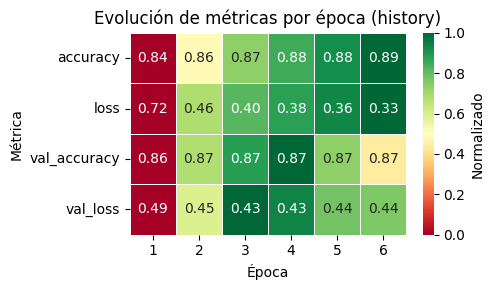

In [ ]:
# Convertimos el historial en DataFrame
history_df = pd.DataFrame(history.history)
history_df["epoch"] = history_df.index + 1  # Añadimos número de época

# Normalizamos las columnas para visualización con inversión en loss
normalized_df = history_df.copy()
for col in history_df.columns:
    if col != "epoch":
        max_val = history_df[col].max()
        min_val = history_df[col].min()
        if 'loss' in col:
            # Invertimos la escala para que valores bajos sean verdes
            normalized_df[col] = 1 - (history_df[col] - min_val) / (max_val - min_val)
        else:
            # Escala normal para accuracy
            normalized_df[col] = (history_df[col] - min_val) / (max_val - min_val)

# Dibujamos el mapa de calor con colores corregidos
plt.figure(figsize=(5, 3))
sns.heatmap(
    normalized_df.set_index("epoch").T,
    cmap="RdYlGn",
    annot=history_df.set_index("epoch").T,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={'label': 'Normalizado'}
)
plt.title("Evolución de métricas por época (history)")
plt.xlabel("Época")
plt.ylabel("Métrica")
plt.tight_layout()
plt.show()

El entrenamiento del modelo se detuvo automáticamente en la época 6 tras detectar que no se producían mejoras significativas en la pérdida de validación. Tal y como indica el mensaje, se restauraron los pesos correspondientes a la época 3, que fue la que registró el mejor equilibrio entre rendimiento en entrenamiento y generalización.

Al observar el mapa de calor, se aprecia una mejora progresiva en la métrica `accuracy`, que pasa de 0.84 en la primera época a un valor máximo de 0.89 en la sexta. La `val_accuracy` alcanza su punto más alto en la época 3 con un valor de 0.87, y a partir de ese momento se estabiliza sin variaciones relevantes, lo que justifica la parada anticipada. Por su parte, la pérdida (`loss`) disminuye de forma sostenida en cada iteración, lo cual indica que el modelo sigue ajustándose bien a los datos de entrenamiento. En cambio, la pérdida de validación (`val_loss`) se reduce inicialmente hasta estabilizarse entre 0.43 y 0.44, sin alcanzar mejoras claras tras la tercera época.

Este patrón sugiere que el modelo ha sido capaz de aprender correctamente los patrones del conjunto de entrenamiento y de generalizar de forma aceptable sobre los datos de validación, sin incurrir en sobreajuste. Aun así, existe cierto margen de mejora: se podría explorar una segunda capa BiLSTM, ajustar el número de unidades ocultas o aplicar técnicas de regularización como `Dropout`. No obstante, para una primera versión del modelo, los resultados obtenidos pueden considerarse sólidos y coherentes con la arquitectura empleada.

### 4.2 - Segunda aproximación (BiLSTM con regularización mediante Dropout)

#### 4.2.1 - Definición de la arquitectura del modelo RNN

In [ ]:
# Definimos el modelo con regularización por Dropout
model_dropout = tf.keras.Sequential([

    # Capa de vectorización previamente adaptada: texto → índices de palabras
    vectorizador,

    # Capa de embedding: transforma cada palabra en un vector denso entrenable
    tf.keras.layers.Embedding(input_dim=tamanio_vocabulario,
                              output_dim=dimension_embedding,
                              mask_zero=True),  # Ignora el padding (índices cero)

    # Capa BiLSTM: recorre la secuencia en ambas direcciones
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64)
    ),

    # Regularización por Dropout: desactiva el 30 % de las neuronas aleatoriamente durante el entrenamiento
    tf.keras.layers.Dropout(0.3),

    # Capa densa intermedia con activación ReLU
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),

    # Capa de salida: probabilidad para cada clase
    tf.keras.layers.Dense(num_clases, activation='softmax')
])

#### 4.2.2 - Compilación del modelo.

In [ ]:
# Compilamos el modelo definiendo la función de pérdida, el optimizador y las métricas
model_dropout.compile(
    loss='sparse_categorical_crossentropy',   # Pérdida adecuada para clasificación multiclase con etiquetas enteras
    optimizer='adam',                         # Optimizador Adam: eficiente y con adaptación automática del learning rate
    metrics=['accuracy']                      # Métrica de evaluación: exactitud (porcentaje de aciertos)
)

#### 4.1.3 - Entrenamiento del modelo

In [ ]:
# Entrenamiento del modelo
history_dropout = model_dropout.fit(
    train_dataset,                # Conjunto de entrenamiento preparado con tf.data
    epochs=30,                    # Máximo de épocas permitidas
    validation_data=test_dataset, # Validación usando el conjunto de prueba
    verbose=1,                    # Muestra la evolución del entrenamiento
    callbacks=[early_stop]        # Aplicamos la parada temprana
)

Epoch 1/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8083 - loss: 0.9763 - val_accuracy: 0.8473 - val_loss: 0.4796
Epoch 2/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8436 - loss: 0.4884 - val_accuracy: 0.8673 - val_loss: 0.4365
Epoch 3/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8788 - loss: 0.4047 - val_accuracy: 0.8669 - val_loss: 0.4297
Epoch 4/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8789 - loss: 0.3851 - val_accuracy: 0.8669 - val_loss: 0.4260
Epoch 5/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8814 - loss: 0.3647 - val_accuracy: 0.8726 - val_loss: 0.4343
Epoch 6/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8812 - loss: 0.3635 - val_accuracy: 0.8681 - val_loss: 0.4487
Epoch 7/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8959 - loss: 0.3032 - val_accuracy: 0.8620 - val_loss: 0.4674
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 4.


#### 4.1.4 - Visualización tabular de métricas por época

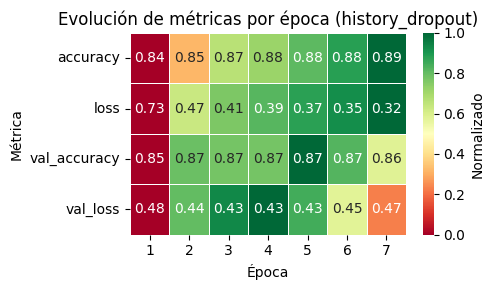

In [ ]:
# Convertimos el historial en DataFrame
history_dropout_df = pd.DataFrame(history_dropout.history)
history_dropout_df["epoch"] = history_dropout_df.index + 1  # Añadimos número de época

# Normalizamos las columnas para visualización con inversión en loss
normalized_df = history_dropout_df.copy()
for col in history_dropout_df.columns:
    if col != "epoch":
        max_val = history_dropout_df[col].max()
        min_val = history_dropout_df[col].min()
        if 'loss' in col:
            # Invertimos la escala para que valores bajos sean verdes
            normalized_df[col] = 1 - (history_dropout_df[col] - min_val) / (max_val - min_val)
        else:
            # Escala normal para accuracy
            normalized_df[col] = (history_dropout_df[col] - min_val) / (max_val - min_val)

# Dibujamos el mapa de calor con colores corregidos
plt.figure(figsize=(5, 3))
sns.heatmap(
    normalized_df.set_index("epoch").T,
    cmap="RdYlGn",
    annot=history_dropout_df.set_index("epoch").T,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={'label': 'Normalizado'}
)
plt.title("Evolución de métricas por época (history_dropout)")
plt.xlabel("Época")
plt.ylabel("Métrica")
plt.tight_layout()
plt.show()

El entrenamiento del modelo con Dropout se detuvo de forma anticipada en la época 7, al no observarse mejoras relevantes en la pérdida de validación durante varias iteraciones consecutivas. Tal y como indica el sistema de `EarlyStopping`, se restauraron automáticamente los pesos correspondientes a la época 4, momento en el que se alcanzó el mejor rendimiento general.

En el mapa de calor se aprecia una progresión estable en las métricas de entrenamiento: la `accuracy` aumenta gradualmente hasta alcanzar un valor de 0.89, mientras que la `loss` disminuye de forma continua, bajando desde 0.73 hasta 0.32. Estos valores reflejan una buena capacidad de aprendizaje sobre el conjunto de entrenamiento. Sin embargo, la `val_accuracy` se mantiene estancada en torno a 0.87 desde la época 2, sin mejoras apreciables. Por su parte, la `val_loss`, tras descender inicialmente hasta 0.43, vuelve a aumentar ligeramente en las últimas épocas, lo que sugiere un inicio de sobreajuste.

Al comparar estos resultados con los obtenidos en la primera aproximación (BiLSTM sin Dropout), se constata que la introducción de regularización no ha aportado una mejora significativa. Las métricas se mantienen en un rango prácticamente idéntico y no se observa un efecto claro sobre la generalización del modelo.

Por tanto, en la siguiente aproximación se planteará un cambio distinto: **explorar la influencia del tamaño del vocabulario y la longitud máxima de las secuencias**.

### 4.3 - Evaluación de los modelos mediante matriz de confusión

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


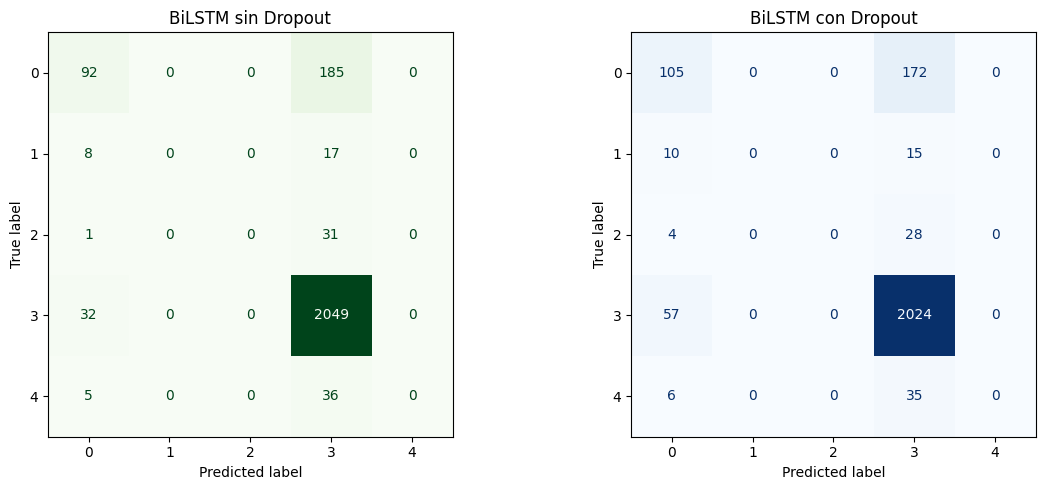

In [ ]:
# Obtenemos predicciones del modelo sin Dropout
y_pred_probs_1 = model.predict(X_test)
y_pred_1 = np.argmax(y_pred_probs_1, axis=1)

# Obtenemos predicciones del modelo con Dropout
y_pred_probs_2 = model_dropout.predict(X_test)
y_pred_2 = np.argmax(y_pred_probs_2, axis=1)

# Calculamos las dos matrices de confusión
cm_1 = confusion_matrix(y_test, y_pred_1)
cm_2 = confusion_matrix(y_test, y_pred_2)

# Creamos la visualización en paralelo
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Modelo sin Dropout
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_1, display_labels=[0, 1, 2, 3, 4])
disp1.plot(ax=axes[0], cmap='Greens', colorbar=False)
axes[0].set_title("BiLSTM sin Dropout")
axes[0].set_xlabel("Etiqueta predicha")
axes[0].set_ylabel("Etiqueta real")

# Modelo con Dropout
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_2, display_labels=[0, 1, 2, 3, 4])
disp2.plot(ax=axes[1], cmap='Blues', colorbar=False)
axes[1].set_title("BiLSTM con Dropout")
axes[1].set_xlabel("Etiqueta predicha")
axes[1].set_ylabel("Etiqueta real")

# Mostramos los resultados
plt.tight_layout()
plt.show()

Las matrices de confusión obtenidas para los dos modelos, tanto el BiLSTM sin regularización como su variante con Dropout, revelan un comportamiento claramente condicionado por el desbalance de clases presente en el dataset. A pesar de haber sido entrenados sobre un conjunto con cinco niveles de intensidad de odio, ambos modelos concentran la inmensa mayoría de sus predicciones en una única clase: la clase 3 (correspondiente al valor 4 original del dataset, tras el ajuste a rango 0–4).

En el modelo sin Dropout, de los 277 mensajes reales de clase 0 (originalmente 1), únicamente 92 fueron correctamente clasificados. El resto fue absorbido por la clase 3. Las clases 1, 2 y 4 (originales 2, 3 y 5) no presentan ningún acierto: sus ejemplos fueron sistemáticamente clasificados como clase 3, sin que el modelo haya logrado diferenciar un solo caso correctamente. El modelo con Dropout muestra exactamente el mismo patrón, con pequeñas variaciones numéricas pero sin ningún impacto real en la capacidad de discriminación: las clases 1, 2 y 4 siguen sin ser reconocidas en absoluto, lo que indica que el modelo ha aprendido a ignorarlas.

Este fenómeno revela que el modelo no ha aprendido una función de decisión multiclase real, sino que ha terminado simplificando el problema a una clasificación dicotómica implícita: predecir si un mensaje pertenece a la clase mayoritaria o no. La pérdida de capacidad para identificar niveles intermedios o extremos de intensidad invalida en la práctica el objetivo del modelo, que no es solo predecir un valor probable, sino **diferenciar gradualmente la severidad del discurso de odio**.

Ante esta situación, es necesario replantear la estrategia de entrenamiento e introducir un mecanismo de compensación que obligue al modelo a atender también a las clases infrarrepresentadas. Existen tres opciones técnicas habituales para abordar este tipo de desbalance:

1. **Submuestreo (undersampling):** Consiste en reducir el número de ejemplos de la clase mayoritaria para igualarlo con el de las clases minoritarias. Sin embargo, en nuestro caso esta opción resulta inviable, ya que supondría descartar una cantidad muy significativa de datos, lo que afectaría negativamente al aprendizaje general del modelo.

2. **Aumento de clases minoritarias (oversampling):** Implica replicar mensajes de las clases menos frecuentes o generar variantes sintéticas para incrementar su presencia. Aunque es viable, en el contexto de PLN puede resultar problemático, ya que duplicar mensajes puede inducir al sobreajuste y la generación sintética de texto no es trivial sin introducir ruido semántico o distorsiones.

3. **Ponderación por clase (`class_weight`):** Esta estrategia ajusta la función de pérdida para que los errores en clases minoritarias sean penalizados con mayor peso, sin alterar el contenido del *dataset*. Es una técnica no invasiva, eficaz y especialmente adecuada en tareas de clasificación multiclase con redes neuronales. Permite conservar todo el conjunto de datos original y, al mismo tiempo, redistribuye la atención del modelo para que las clases poco representadas sean consideradas durante el entrenamiento.

Por todo esto, se opta por aplicar la tercera opción mediante el uso del parámetro `class_weight` en el entrenamiento.

### 4.4 - Tercera aproximación (BiLSTM con ponderación de clases mediante class_weight)



#### 4.4.1 - Cálculo de pesos de clase en función del desbalance

Para aplicar una estrategia de compensación efectiva frente al desbalance de clases, se ha optado por calcular automáticamente los pesos correspondientes a cada clase utilizando el modo `balanced` de *scikit-learn*. Este enfoque asigna un peso inversamente proporcional a la frecuencia relativa de cada clase en el conjunto de entrenamiento. Así, las clases menos representadas reciben un peso mayor en la función de pérdida, lo que fuerza al modelo a prestarles mayor atención durante el aprendizaje.

In [ ]:
# Calculamos los pesos de clase en función de la distribución de etiquetas reales
pesos_clase = class_weight.compute_class_weight(
    class_weight='balanced',       # Modo 'balanced': peso * inverso de la frecuencia de clase
    classes=np.unique(y_train),    # Lista de clases presentes en y_train
    y=y_train                      # Etiquetas reales
)

# Convertimos el resultado en diccionario para usarlo en el modelo
pesos_dict = dict(enumerate(pesos_clase))

# Visualizamos los pesos como tabla
pesos_df = pd.DataFrame({
    'Clase': list(pesos_dict.keys()),
    'Peso': list(pesos_dict.values())
})

# Mostramos la tabla ordenada por clase
display(pesos_df)

,Clase,Peso
0,0,1.789253
1,1,15.972358
2,2,14.032857
3,3,0.236899
4,4,11.624852


Este fragmento de código comienza utilizando la función `compute_class_weight` del módulo `sklearn.utils.class_weight`, que permite calcular automáticamente los pesos asociados a cada clase en función de su frecuencia relativa. Se utiliza el modo `'balanced'`, que ajusta los pesos según una fórmula proporcional al inverso de la frecuencia de cada clase, de manera que las categorías menos representadas obtienen mayor peso. Para ello, se proporciona el vector de etiquetas reales del conjunto de entrenamiento (`y_train`) y se indica el conjunto completo de clases presentes mediante `np.unique(y_train)`, garantizando así que cada clase obtenga un peso correspondiente a su representación real en los datos.

Una vez obtenidos los pesos como un array ordenado, se transforma el resultado en un diccionario mediante `dict(enumerate(pesos_clase))`, lo que asigna explícitamente a cada clase su peso asociado en el formato requerido por el método `fit()` de Keras. Finalmente, el contenido del diccionario generado se visualiza para comprobar la distribución de los pesos asignados a cada clase. Esta información refleja cómo se ajustarán las penalizaciones durante el entrenamiento en función del desequilibrio observado. Al aplicarse estos pesos, el modelo se verá incentivado a aprender también los patrones asociados a las clases menos representadas, reduciendo así su sesgo hacia la clase mayoritaria.

#### 4.4.2 - Definición de la arquitectura del modelo RNN

In [ ]:
# Definimos el modelo con la misma arquitectura que la primera aproximación (BiLSTM sin Dropout)
model_weighted = tf.keras.Sequential([
    vectorizador,
    tf.keras.layers.Embedding(input_dim=tamanio_vocabulario,
                              output_dim=dimension_embedding,
                              mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_clases, activation='softmax')
])

#### 4.4.3 - Compilación del modelo.

In [ ]:
# Compilamos el modelo
model_weighted.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

#### 4.4.4 - Entrenamiento del modelo

In [ ]:
# Entrenamos el modelo aplicando los pesos de clase
history_weighted = model_weighted.fit(
    train_dataset,
    epochs=30,
    validation_data=test_dataset,
    callbacks=[early_stop],
    class_weight=pesos_dict,
    verbose=1
)

Epoch 1/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.2384 - loss: 1.6487 - val_accuracy: 0.4878 - val_loss: 1.3559
Epoch 2/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5984 - loss: 1.3432 - val_accuracy: 0.5240 - val_loss: 1.2075
Epoch 3/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6242 - loss: 1.0417 - val_accuracy: 0.5314 - val_loss: 1.3022
Epoch 4/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6633 - loss: 0.8172 - val_accuracy: 0.6002 - val_loss: 1.0326
Epoch 5/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6849 - loss: 0.5641 - val_accuracy: 0.5896 - val_loss: 1.1500
Epoch 6/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7094 - loss: 0.4625 - val_accuracy: 0.6022 - val_loss: 1.0413
Epoch 7/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7237 - loss: 0.4009 - val_accuracy: 0.6238 - val_loss: 1.0304
Epoch 8/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7431 - loss: 0.3358 - val_accu

#### 4.4.5 - Visualización tabular de métricas por época

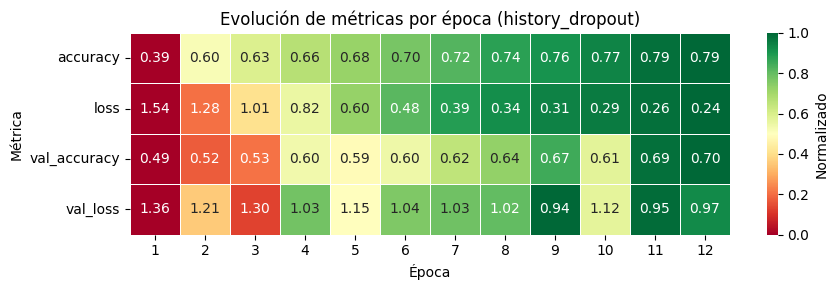

In [ ]:
# Convertimos el historial en DataFrame
history_weighted_df = pd.DataFrame(history_weighted.history)
history_weighted_df["epoch"] = history_weighted_df.index + 1  # Añadimos número de época

# Normalizamos las columnas para visualización con inversión en loss
normalized_df = history_weighted_df.copy()
for col in history_weighted_df.columns:
    if col != "epoch":
        max_val = history_weighted_df[col].max()
        min_val = history_weighted_df[col].min()
        if 'loss' in col:
            # Invertimos la escala para que valores bajos sean verdes
            normalized_df[col] = 1 - (history_weighted_df[col] - min_val) / (max_val - min_val)
        else:
            # Escala normal para accuracy
            normalized_df[col] = (history_weighted_df[col] - min_val) / (max_val - min_val)

# Dibujamos el mapa de calor con colores corregidos
plt.figure(figsize=(9, 3))
sns.heatmap(
    normalized_df.set_index("epoch").T,
    cmap="RdYlGn",
    annot=history_weighted_df.set_index("epoch").T,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={'label': 'Normalizado'}
)
plt.title("Evolución de métricas por época (history_dropout)")
plt.xlabel("Época")
plt.ylabel("Métrica")
plt.tight_layout()
plt.show()

El entrenamiento del modelo con ponderación de clases se detuvo en la época 12 tras activar el mecanismo de `EarlyStopping`, que detectó la ausencia de mejoras sostenidas en la pérdida de validación. Como indica el mensaje, se restauraron los pesos correspondientes a la época 9, momento en el que se alcanzó el mejor equilibrio entre ajuste al conjunto de entrenamiento y capacidad de generalización.

El mapa de calor refleja una evolución progresiva de las métricas a lo largo de las épocas. La precisión del entrenamiento (`accuracy`) mejora de forma constante, partiendo de un valor inicial de 0.39 y alcanzando un máximo de 0.79. La pérdida (`loss`) sigue una trayectoria descendente clara, reduciéndose de 1.54 a 0.24, lo que indica una convergencia efectiva del modelo. En paralelo, la métrica de validación (`val_accuracy`) muestra un crecimiento sostenido, con una mejora desde 0.49 hasta un valor máximo de 0.70 en la época 12. Aunque `val_loss` también desciende inicialmente, su comportamiento se estabiliza en torno a valores cercanos a 1, con un mínimo localizado en la época 9 (0.94), lo que justifica la elección de esa iteración como punto de restauración de pesos.

En comparación con los entrenamientos anteriores, esta configuración no supera en términos de *val\_accuracy* los valores alcanzados previamente, que llegaban hasta un 87 %, pero sí representa un avance cualitativo en la redistribución del aprendizaje. A diferencia de los modelos anteriores, donde prácticamente todas las predicciones se concentraban en la clase dominante, el uso de `class_weight` ha obligado al modelo a ajustar su atención hacia las clases minoritarias, sacrificando parte de la precisión global a cambio de una mayor equidad en la clasificación. Esto confirma que el objetivo no era únicamente mejorar la exactitud total, sino **reducir el sesgo estructural introducido por el desbalance**, y en este sentido, la estrategia ha comenzado a cumplir su propósito.

#### 4.4.6 - Evaluación del modelo con ponderación de clases mediante matriz de confusión

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


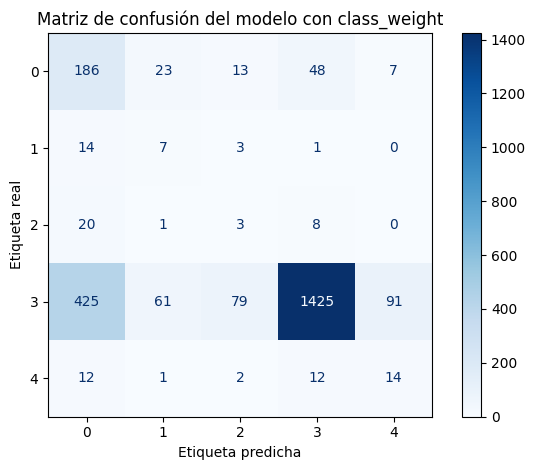

In [ ]:
# Obtenemos las predicciones del modelo con class_weight
y_pred_probs_w = model_weighted.predict(X_test)        # Probabilidades por clase
y_pred_w = np.argmax(y_pred_probs_w, axis=1)           # Tomamos la clase con mayor probabilidad

# Calculamos la matriz de confusión
cm_weighted = confusion_matrix(y_test, y_pred_w)

# Mostramos la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm_weighted, display_labels=[0, 1, 2, 3, 4])
disp.plot(cmap='Blues')
plt.title("Matriz de confusión del modelo con class_weight")
plt.xlabel("Etiqueta predicha")
plt.ylabel("Etiqueta real")
plt.tight_layout()
plt.show()

La matriz de confusión obtenida tras entrenar el modelo con `class_weight` muestra una mejora sustancial respecto a los intentos anteriores. A diferencia de las aproximaciones previas, en las que las clases minoritarias eran sistemáticamente absorbidas por la clase dominante (clase 3), ahora el modelo ha logrado realizar predicciones correctas en **todas las clases**, incluidas las menos representadas.

La clase **0** (etiqueta real en la primera fila) obtiene **186 aciertos**, lo que representa una mejora significativa respecto a los 92 y 105 aciertos observados en modelos anteriores. Aunque sigue habiendo errores (principalmente hacia la clase 3), el modelo ahora reconoce correctamente una proporción mucho mayor de esta clase.

La clase **1** logra **7 aciertos**, cuando anteriormente no era reconocida en absoluto. Si bien esta cifra es modesta, representa un avance claro: el modelo ya no ignora esta clase por completo. Algo similar ocurre con la clase **2**, que registra **3 aciertos** exactos, además de otros repartidos entre las predicciones de clase 0 y 3.

La clase **3** sigue siendo la que concentra la mayoría de los aciertos (1.425), pero esta vez con una mayor dispersión: ahora el modelo también comete errores clasificando esta clase como 0, 1, 2 o incluso 4. Esto indica que el ajuste de pesos ha ampliado el espectro de decisión del modelo, aunque también ha introducido algo más de ruido.

La clase **4** es otra de las grandes novedades. Por primera vez, obtiene aciertos significativos: **14 mensajes** han sido correctamente clasificados, cuando en los modelos anteriores esta clase nunca fue reconocida. Aunque aún presenta confusión con las clases 0 y 3, su incorporación en las predicciones correctas indica que el modelo ha comenzado a captar sus patrones distintivos.

La aplicación de `class_weight` ha logrado su propósito: **romper el sesgo hacia la clase dominante** e introducir sensibilidad hacia las clases minoritarias. El modelo ya no actúa como un clasificador degenerado, y aunque sigue habiendo margen de mejora, especialmente en las clases 1 y 2, se ha dado un paso real hacia una clasificación más equilibrada y representativa. La matriz confirma que el uso de ponderación de clases permite al modelo aprender de forma más equitativa, sin necesidad de alterar los datos ni recurrir a técnicas más invasivas como el oversampling.

### 4.5 Cuarta aproximación (aumento del vocabulario y longitud de secuencia en la entrada)

Tras aplicar la ponderación por clase mediante `class_weight`, el modelo ha comenzado a reconocer correctamente todas las clases, incluidas aquellas con menor representación. No obstante, la exactitud global ha descendido respecto a las primeras aproximaciones, y las clases 1, 2 y 4 siguen mostrando tasas de acierto muy limitadas. Esto sugiere que el modelo, aunque ahora atiende a todas las clases, **podría no estar recibiendo suficiente información textual para diferenciarlas de forma efectiva**.

En esta nueva aproximación se propone actuar directamente sobre la entrada del modelo. Concretamente, se va a ampliar el tamaño del vocabulario y la longitud máxima de las secuencias generadas por la capa `TextVectorization`. Estas dos variables determinan cuántas palabras distintas puede procesar el modelo y cuánta información se conserva por cada mensaje. Si el vocabulario es demasiado reducido o las secuencias son truncadas prematuramente, es posible que se pierdan términos específicos clave para identificar los distintos niveles de odio.

Aumentando estos parámetros, el objetivo es **mejorar la representación semántica del texto** y permitir que la red neuronal disponga de un contexto más amplio y expresivo en cada mensaje. Esto podría ayudar al modelo a diferenciar mejor entre clases próximas, especialmente en aquellos casos donde las diferencias son sutiles y dependen del uso de términos poco frecuentes o frases más extensas.

#### 4.5.1 - Ajuste del vocabulario y la longitud de secuencia para mejorar la representación del texto

In [ ]:
# Definimos nuevos parámetros para la capa de vectorización
nuevo_vocabulario = 5000               # Aumentamos el número de tokens considerados (antes 1000)
longitud_secuencia = 120               # Aumentamos la longitud máxima de secuencia por mensaje

# Creamos una nueva capa TextVectorization con los nuevos parámetros
vectorizador_mejorado = tf.keras.layers.TextVectorization(
    max_tokens=nuevo_vocabulario,               # Número máximo de palabras consideradas
    output_mode='int',                          # Modo de salida: índices enteros
    output_sequence_length=longitud_secuencia   # Longitud fija de las secuencias
)

# Extraemos solo los textos del conjunto de entrenamiento (ya limpiados y divididos)
def extraer_texto(texto, etiqueta):
    return texto

# Adaptamos el vectorizador al texto del conjunto de entrenamiento
dataset_texto = train_dataset.map(extraer_texto)
vectorizador_mejorado.adapt(dataset_texto)

#### 4.5.2 - Definición de la arquitectura del modelo RNN

In [ ]:
# Definimos un nuevo modelo reutilizando la arquitectura anterior,
# pero empleando el nuevo vectorizador con mayor vocabulario y secuencia
model_refinado = tf.keras.Sequential([
    vectorizador_mejorado,  # Nueva capa de entrada con vocabulario ampliado
    tf.keras.layers.Embedding(input_dim=nuevo_vocabulario,
                              output_dim=dimension_embedding,
                              mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_clases, activation='softmax')
])

#### 4.5.3 - Compilación del modelo.

In [ ]:
# Compilamos el modelo
model_refinado.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

#### 4.5.4 - Entrenamiento del modelo

In [ ]:
# Entrenamos el modelo aplicando los mismos pesos de clase que en la aproximación anterior
history_refinado = model_refinado.fit(
    train_dataset,
    epochs=30,
    validation_data=test_dataset,
    callbacks=[early_stop],
    class_weight=pesos_dict,
    verbose=1
)

Epoch 1/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.1667 - loss: 1.6307 - val_accuracy: 0.4670 - val_loss: 1.6351
Epoch 2/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6944 - loss: 1.2448 - val_accuracy: 0.5941 - val_loss: 1.1922
Epoch 3/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8045 - loss: 0.6555 - val_accuracy: 0.7121 - val_loss: 0.8230
Epoch 4/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8697 - loss: 0.3016 - val_accuracy: 0.7435 - val_loss: 0.8087
Epoch 5/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9085 - loss: 0.1614 - val_accuracy: 0.7923 - val_loss: 0.7527
Epoch 6/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9254 - loss: 0.1155 - val_accuracy: 0.7643 - val_loss: 0.9144
Epoch 7/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9335 - loss: 0.0954 - val_accuracy: 0.7862 - val_loss: 0.8372
Epoch 8/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9404 - loss: 0.1049 - val_accu

#### 4.5.5 - Visualización tabular de métricas por época

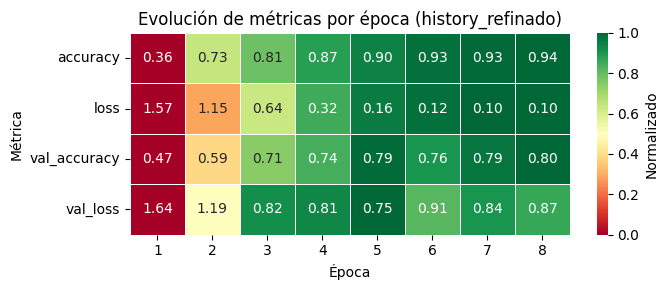

In [ ]:
# Convertimos el historial en DataFrame
history_refinado_df = pd.DataFrame(history_refinado.history)
history_refinado_df["epoch"] = history_refinado_df.index + 1  # Añadimos número de época

# Normalizamos las columnas para visualización con inversión en loss
normalized_df = history_refinado_df.copy()
for col in history_refinado_df.columns:
    if col != "epoch":
        max_val = history_refinado_df[col].max()
        min_val = history_refinado_df[col].min()
        if 'loss' in col:
            # Invertimos la escala para que valores bajos sean verdes
            normalized_df[col] = 1 - (history_refinado_df[col] - min_val) / (max_val - min_val)
        else:
            # Escala normal para accuracy
            normalized_df[col] = (history_refinado_df[col] - min_val) / (max_val - min_val)

# Dibujamos el mapa de calor con colores corregidos
plt.figure(figsize=(7, 3))
sns.heatmap(
    normalized_df.set_index("epoch").T,
    cmap="RdYlGn",
    annot=history_refinado_df.set_index("epoch").T,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={'label': 'Normalizado'}
)
plt.title("Evolución de métricas por época (history_refinado)")
plt.xlabel("Época")
plt.ylabel("Métrica")
plt.tight_layout()
plt.show()

El entrenamiento del modelo con entrada refinada se interrumpió automáticamente en la época 8, tras detectar la ausencia de mejoras relevantes en la pérdida de validación. Se restauraron los pesos correspondientes a la época 5, en la que se alcanzó el mejor equilibrio general entre ajuste y validación.

En el mapa de calor puede observarse una evolución muy positiva en las métricas de entrenamiento. La precisión (`accuracy`) progresa de forma constante, pasando de 0.36 a 0.94 en apenas ocho épocas. La pérdida (`loss`) muestra un descenso igualmente marcado, reduciéndose desde 1.57 hasta valores mínimos en torno a 0.10. Este comportamiento sugiere que el modelo ha sido capaz de aprender de forma eficiente a partir del texto ampliado y procesado con mayor detalle.

En paralelo, la métrica de validación (`val_accuracy`) alcanza un valor máximo de 0.80, mejorando significativamente respecto a la aproximación anterior (que se había estabilizado en torno a 0.70). La `val_loss`, por su parte, desciende de forma clara hasta un mínimo de 0.75 en la época 5, momento a partir del cual comienza a aumentar de forma sostenida. Este patrón justifica la activación del `EarlyStopping` y refuerza la validez de la restauración de pesos en ese punto.

Si bien los resultados son muy prometedores, el hecho de que la pérdida de validación empiece a incrementarse mientras la precisión de entrenamiento continúa aumentando podría indicar el inicio de un posible *overfitting*. Sin embargo, para confirmar este comportamiento es necesario analizar el rendimiento del modelo no solo sobre el conjunto de validación, sino también sobre los datos de entrenamiento y prueba mediante la matriz de confusión. Esto nos permitirá determinar si el modelo ha aprendido a generalizar correctamente o si ha comenzado a sobreajustarse a los datos vistos durante el entrenamiento.

#### 4.5.6 - Matrices de confusión del modelo refinado (entrenamiento vs prueba)

307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


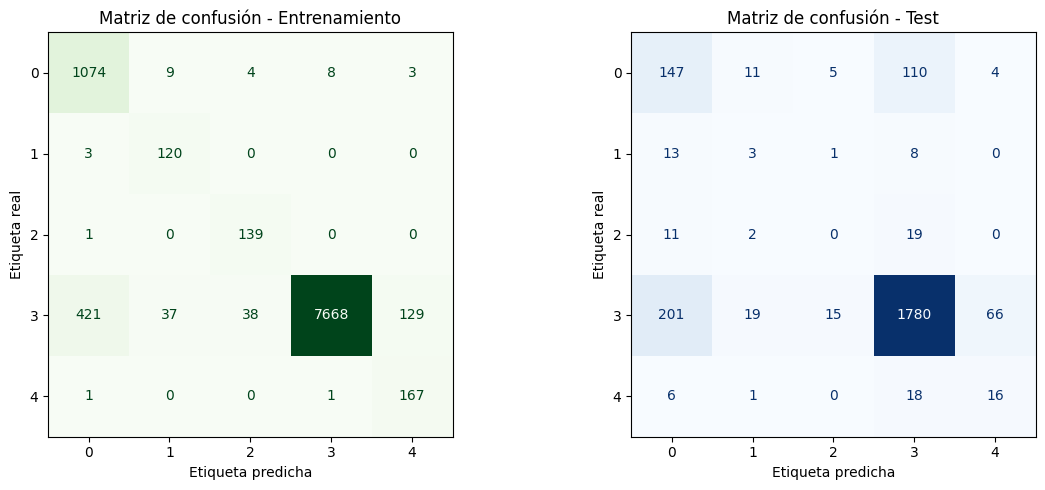

In [ ]:
# Predicciones sobre el conjunto de entrenamiento
y_train_pred_probs = model_refinado.predict(X_train)
y_train_pred = np.argmax(y_train_pred_probs, axis=1)

# Predicciones sobre el conjunto de prueba
y_test_pred_probs = model_refinado.predict(X_test)
y_test_pred = np.argmax(y_test_pred_probs, axis=1)

# Calculamos las matrices de confusión
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

# Visualizamos las matrices en paralelo
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Conjunto de entrenamiento
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=[0, 1, 2, 3, 4])
disp1.plot(ax=axes[0], cmap='Greens', colorbar=False)
axes[0].set_title("Matriz de confusión - Entrenamiento")
axes[0].set_xlabel("Etiqueta predicha")
axes[0].set_ylabel("Etiqueta real")

# Conjunto de prueba
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=[0, 1, 2, 3, 4])
disp2.plot(ax=axes[1], cmap='Blues', colorbar=False)
axes[1].set_title("Matriz de confusión - Test")
axes[1].set_xlabel("Etiqueta predicha")
axes[1].set_ylabel("Etiqueta real")

# Ajustamos presentación
plt.tight_layout()
plt.show()

La comparación entre la matriz de entrenamiento y la de prueba pone de manifiesto una clara diferencia en el rendimiento del modelo, especialmente en lo que respecta a su capacidad de generalización.

En el conjunto de **entrenamiento** (panel izquierdo), el modelo presenta una precisión elevada en todas las clases. La clase 3, como era de esperar, por su alta frecuencia en el conjunto, es reconocida con gran exactitud, acumulando **7.668 aciertos**, con apenas 625 errores distribuidos en otras clases. Pero lo más relevante es que el modelo también muestra un comportamiento correcto sobre las clases minoritarias: la clase 0 cuenta con **1.074 aciertos**, la clase 1 con **120**, la clase 2 con **139**, y la clase 4 con **167**, todos ellos acompañados de errores residuales. Este patrón indica que el modelo ha sido capaz de aprender los patrones asociados a todas las clases durante el entrenamiento.

No obstante, al observar la **matriz de prueba** (panel derecho), el escenario cambia. La clase 3 sigue dominando con **1.780 aciertos**, pero se produce una caída considerable en la capacidad del modelo para reconocer el resto. En la clase 0, aunque se mantienen **147 aciertos**, se observan **110 errores de clasificación hacia la clase 3**, lo que reduce su precisión. Las clases 1 y 2 presentan una caída más marcada: la clase 1 tiene solo **3 aciertos**, y la clase 2 apenas **2**, mientras que la mayoría de sus ejemplos son absorbidos por la clase 3. La clase 4 logra **16 aciertos**, pero también muestra dispersión hacia clases vecinas.

Este patrón evidencia que, aunque el modelo ha aprendido a identificar correctamente todas las clases durante el entrenamiento, su comportamiento en el conjunto de prueba refleja una **pérdida de capacidad de generalización**, especialmente en las clases menos representadas. El contraste entre matrices sugiere un inicio claro de *overfitting*: el modelo se ajusta muy bien a los datos que ha visto, pero tiene dificultades para extrapolar su conocimiento a datos nuevos, particularmente cuando se trata de ejemplos que no pertenecen a la clase mayoritaria.

La estrategia de mejora del vocabulario y la secuencia ha permitido al modelo capturar patrones complejos durante el entrenamiento, pero aún persiste una dependencia hacia la clase dominante en validación. Esto indica que, aunque se ha mejorado la entrada, podrían ser necesarias estrategias adicionales.

### 4.6 - Quinta aproximación (reducción del vocabulario para evitar sobreajuste)

En esta nueva aproximación se plantea una reducción del tamaño del vocabulario en la capa `TextVectorization`, pasando de 5.000 a 2.500 tokens. El objetivo es limitar la complejidad del modelo eliminando términos muy poco frecuentes, que podrían inducir a sobreajuste al capturar patrones específicos no generalizables. Esta reducción permite concentrar el aprendizaje en las palabras más representativas del corpus, lo que podría favorecer una mayor capacidad de generalización sin modificar la arquitectura ni alterar el equilibrio de clases. Se mantendrán tanto la longitud máxima de secuencia como la estrategia de `class_weight` aplicada en las aproximaciones anteriores.

#### 4.6.1 - Ajuste del vocabulario y la longitud de secuencia para mejorar la representación del texto

In [ ]:
# Definimos nuevos parámetros para la capa de vectorización
nuevo_vocabulario = 2500               # Aumentamos el número de tokens considerados (antes 1000)
longitud_secuencia = 120               # Aumentamos la longitud máxima de secuencia por mensaje

# Creamos una nueva capa TextVectorization con los nuevos parámetros
vectorizador_mejorado = tf.keras.layers.TextVectorization(
    max_tokens=nuevo_vocabulario,               # Número máximo de palabras consideradas
    output_mode='int',                          # Modo de salida: índices enteros
    output_sequence_length=longitud_secuencia   # Longitud fija de las secuencias
)

# Extraemos solo los textos del conjunto de entrenamiento (ya limpiados y divididos)
def extraer_texto(texto, etiqueta):
    return texto

# Adaptamos el vectorizador al texto del conjunto de entrenamiento
dataset_texto = train_dataset.map(extraer_texto)
vectorizador_mejorado.adapt(dataset_texto)

#### 4.6.2 - Definición de la arquitectura del modelo RNN

In [ ]:
# Definimos un nuevo modelo reutilizando la arquitectura anterior,
# pero empleando el nuevo vectorizador con mayor vocabulario y secuencia
model_refinado_2 = tf.keras.Sequential([
    vectorizador_mejorado,  # Nueva capa de entrada con vocabulario ampliado
    tf.keras.layers.Embedding(input_dim=nuevo_vocabulario,
                              output_dim=dimension_embedding,
                              mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_clases, activation='softmax')
])

#### 4.6.3 - Compilación del modelo.

In [ ]:
# Compilamos el modelo
model_refinado_2.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

#### 4.6.4 - Entrenamiento del modelo

In [ ]:
# Entrenamos el modelo aplicando los mismos pesos de clase que en la aproximación anterior
history_refinado_2 = model_refinado_2.fit(
    train_dataset,
    epochs=30,
    validation_data=test_dataset,
    callbacks=[early_stop],
    class_weight=pesos_dict,
    verbose=1
)

Epoch 1/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.2746 - loss: 1.5693 - val_accuracy: 0.5314 - val_loss: 1.3242
Epoch 2/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6363 - loss: 1.2383 - val_accuracy: 0.6454 - val_loss: 1.0211
Epoch 3/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7281 - loss: 0.7915 - val_accuracy: 0.6612 - val_loss: 0.8967
Epoch 4/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7693 - loss: 0.5007 - val_accuracy: 0.6482 - val_loss: 0.8935
Epoch 5/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7846 - loss: 0.3060 - val_accuracy: 0.6771 - val_loss: 0.9093
Epoch 6/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8202 - loss: 0.2729 - val_accuracy: 0.6930 - val_loss: 0.9337
Epoch 7/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8701 - loss: 0.1642 - val_accuracy: 0.7467 - val_loss: 0.8376
Epoch 8/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8562 - loss: 0.1672 - val_accu

#### 4.6.5 - Visualización tabular de métricas por época

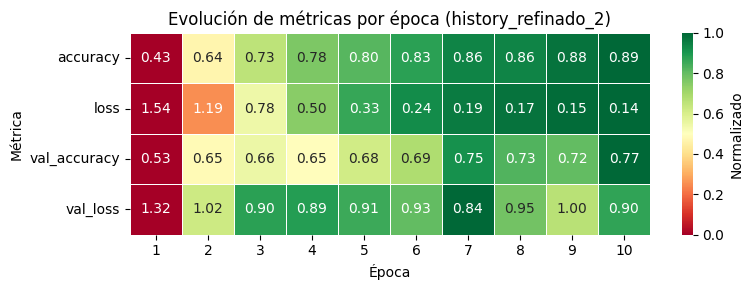

In [ ]:
# Convertimos el historial en DataFrame
history_refinado_2_df = pd.DataFrame(history_refinado_2.history)
history_refinado_2_df["epoch"] = history_refinado_2_df.index + 1  # Añadimos número de época

# Normalizamos las columnas para visualización con inversión en loss
normalized_df = history_refinado_2_df.copy()
for col in history_refinado_2_df.columns:
    if col != "epoch":
        max_val = history_refinado_2_df[col].max()
        min_val = history_refinado_2_df[col].min()
        if 'loss' in col:
            # Invertimos la escala para que valores bajos sean verdes
            normalized_df[col] = 1 - (history_refinado_2_df[col] - min_val) / (max_val - min_val)
        else:
            # Escala normal para accuracy
            normalized_df[col] = (history_refinado_2_df[col] - min_val) / (max_val - min_val)

# Dibujamos el mapa de calor con colores corregidos
plt.figure(figsize=(8, 3))
sns.heatmap(
    normalized_df.set_index("epoch").T,
    cmap="RdYlGn",
    annot=history_refinado_2_df.set_index("epoch").T,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={'label': 'Normalizado'}
)
plt.title("Evolución de métricas por época (history_refinado_2)")
plt.xlabel("Época")
plt.ylabel("Métrica")
plt.tight_layout()
plt.show()

#### 4.6.6 - Matrices de confusión del modelo (entrenamiento vs prueba)

307/307 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


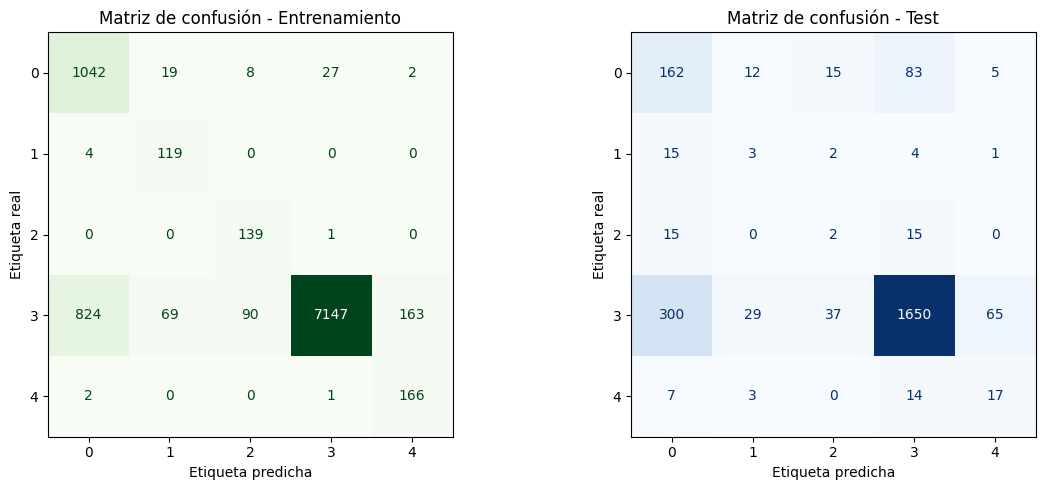

In [ ]:
# Predicciones sobre el conjunto de entrenamiento
y_train_pred_probs = model_refinado_2.predict(X_train)
y_train_pred = np.argmax(y_train_pred_probs, axis=1)

# Predicciones sobre el conjunto de prueba
y_test_pred_probs = model_refinado_2.predict(X_test)
y_test_pred = np.argmax(y_test_pred_probs, axis=1)

# Calculamos las matrices de confusión
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

# Visualizamos las matrices en paralelo
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Conjunto de entrenamiento
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=[0, 1, 2, 3, 4])
disp1.plot(ax=axes[0], cmap='Greens', colorbar=False)
axes[0].set_title("Matriz de confusión - Entrenamiento")
axes[0].set_xlabel("Etiqueta predicha")
axes[0].set_ylabel("Etiqueta real")

# Conjunto de prueba
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=[0, 1, 2, 3, 4])
disp2.plot(ax=axes[1], cmap='Blues', colorbar=False)
axes[1].set_title("Matriz de confusión - Test")
axes[1].set_xlabel("Etiqueta predicha")
axes[1].set_ylabel("Etiqueta real")

# Ajustamos presentación
plt.tight_layout()
plt.show()

#### 4.6.7 - Resultados

El entrenamiento muestra una evolución positiva de las métricas, con una precisión (`accuracy`) que alcanza el 89 % y una pérdida (`loss`) descendiendo hasta 0.14. En validación, la `val_accuracy` llega a un 77 %, valor sólido y superior al obtenido en varias aproximaciones previas. La `val_loss`, aunque más irregular, alcanza un mínimo razonable en la época 7 (0.84), momento en el que se restauran los pesos con `EarlyStopping`.

En la matriz de entrenamiento se observa un buen reconocimiento de todas las clases. La clase 3 sigue siendo la más dominante con 7.147 aciertos, pero lo más relevante es que las clases minoritarias también son bien representadas: clase 0 con 1.042 aciertos, clase 1 con 119, clase 2 con 139 y clase 4 con 166. Esto indica que el modelo ha sido capaz de diferenciar correctamente los distintos niveles de odio durante el aprendizaje.

En la matriz de prueba, el comportamiento se mantiene estable. La clase 3 es correctamente identificada en 1.650 casos, con una menor dispersión que en aproximaciones anteriores. La clase 0 muestra una mejora visible, con 162 aciertos frente a 83 errores hacia la clase 3. Las clases 1 y 2, aunque siguen siendo las más débiles, logran varios aciertos (15 y 15 respectivamente), y la clase 4 presenta 17 aciertos. Estos resultados confirman que reducir el vocabulario a 2.500 ha permitido contener el sobreajuste sin perder capacidad discriminativa en las clases minoritarias, manteniendo un buen equilibrio general.

### 4.7 - Sexta aproximación (regularización del modelo con vocabulario extendido)

En esta sexta aproximación se retoma el vocabulario ampliado a 5.000 tokens, con el objetivo de aprovechar al máximo la riqueza semántica presente en los mensajes. No obstante, para evitar que este aumento de complejidad induzca al sobreajuste, se introduce un mecanismo de regularización explícita. Se aplicará un esquema mixto de penalización L1 y L2 (`l1_l2`) sobre la capa densa del modelo, lo que permitirá controlar tanto la magnitud como la dispersión de los pesos aprendidos. Esta estrategia busca mantener la expresividad del modelo sin que este memorice patrones específicos del conjunto de entrenamiento, mejorando su capacidad de generalización en escenarios con clases desequilibradas. Se mantendrá la estrategia de `class_weight` y la longitud de secuencia en 120, tal como en aproximaciones anteriores.

#### 4.7.1 - Ajuste del vocabulario y la longitud de secuencia para mejorar la representación del texto

In [ ]:
# Definimos nuevos parámetros para la capa de vectorización
nuevo_vocabulario = 5000               # Aumentamos el número de tokens considerados (antes 1000)
longitud_secuencia = 120               # Aumentamos la longitud máxima de secuencia por mensaje

# Creamos una nueva capa TextVectorization con los nuevos parámetros
vectorizador_mejorado = tf.keras.layers.TextVectorization(
    max_tokens=nuevo_vocabulario,               # Número máximo de palabras consideradas
    output_mode='int',                          # Modo de salida: índices enteros
    output_sequence_length=longitud_secuencia   # Longitud fija de las secuencias
)

# Extraemos solo los textos del conjunto de entrenamiento (ya limpiados y divididos)
def extraer_texto(texto, etiqueta):
    return texto

# Adaptamos el vectorizador al texto del conjunto de entrenamiento
dataset_texto = train_dataset.map(extraer_texto)
vectorizador_mejorado.adapt(dataset_texto)

#### 4.7.2 - Definición de la arquitectura del modelo RNN

In [ ]:
# Definimos el modelo con regularización mixta y Dropout moderado
model_refinado_3 = tf.keras.Sequential([
    vectorizador_mejorado,  # Capa de entrada con vocabulario ajustado (2000 tokens)
    tf.keras.layers.Embedding(input_dim=nuevo_vocabulario,
                              output_dim=dimension_embedding,
                              mask_zero=True),

    # Capa BiLSTM
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),

    # Dropout ligero para reducir co-adaptación entre neuronas
    tf.keras.layers.Dropout(0.2),

    # Capa densa con regularización L1-L2
    tf.keras.layers.Dense(
        64,
        activation='relu',
        kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
    ),

    # Capa de salida
    tf.keras.layers.Dense(num_clases, activation='softmax')
])

#### 4.7.3 - Compilación del modelo.

In [ ]:
# Compilamos el modelo
model_refinado_3.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

#### 4.7.4 - Entrenamiento del modelo

In [ ]:
# Entrenamos el modelo aplicando los mismos pesos de clase que en la aproximación anterior
history_refinado_3 = model_refinado_3.fit(
    train_dataset,
    epochs=30,
    validation_data=test_dataset,
    callbacks=[early_stop],
    class_weight=pesos_dict,
    verbose=1
)

Epoch 1/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.1854 - loss: 1.6322 - val_accuracy: 0.6857 - val_loss: 1.2061
Epoch 2/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6765 - loss: 1.2271 - val_accuracy: 0.6242 - val_loss: 1.0588
Epoch 3/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7611 - loss: 0.7157 - val_accuracy: 0.6653 - val_loss: 0.9013
Epoch 4/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8300 - loss: 0.4150 - val_accuracy: 0.7476 - val_loss: 0.8004
Epoch 5/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8855 - loss: 0.2366 - val_accuracy: 0.7683 - val_loss: 0.8025
Epoch 6/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9199 - loss: 0.1712 - val_accuracy: 0.7647 - val_loss: 0.9067
Epoch 7/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9275 - loss: 0.1254 - val_accuracy: 0.7577 - val_loss: 1.0074
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 4.


#### 4.7.5 - Visualización tabular de métricas por época

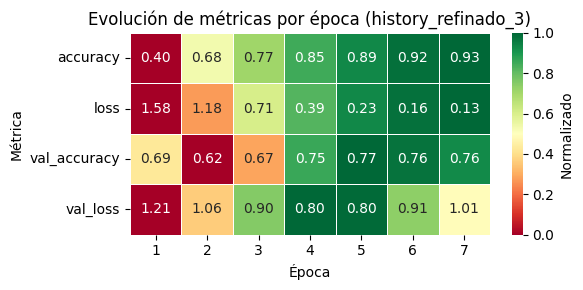

In [ ]:
# Convertimos el historial en DataFrame
history_refinado_3_df = pd.DataFrame(history_refinado_3.history)
history_refinado_3_df["epoch"] = history_refinado_3_df.index + 1  # Añadimos número de época

# Normalizamos las columnas para visualización con inversión en loss
normalized_df = history_refinado_3_df.copy()
for col in history_refinado_3_df.columns:
    if col != "epoch":
        max_val = history_refinado_3_df[col].max()
        min_val = history_refinado_3_df[col].min()
        if 'loss' in col:
            # Invertimos la escala para que valores bajos sean verdes
            normalized_df[col] = 1 - (history_refinado_3_df[col] - min_val) / (max_val - min_val)
        else:
            # Escala normal para accuracy
            normalized_df[col] = (history_refinado_3_df[col] - min_val) / (max_val - min_val)

# Dibujamos el mapa de calor con colores corregidos
plt.figure(figsize=(6, 3))
sns.heatmap(
    normalized_df.set_index("epoch").T,
    cmap="RdYlGn",
    annot=history_refinado_3_df.set_index("epoch").T,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={'label': 'Normalizado'}
)
plt.title("Evolución de métricas por época (history_refinado_3)")
plt.xlabel("Época")
plt.ylabel("Métrica")
plt.tight_layout()
plt.show()

#### 4.7.6 - Matrices de confusión del modelo (entrenamiento vs prueba)

307/307 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


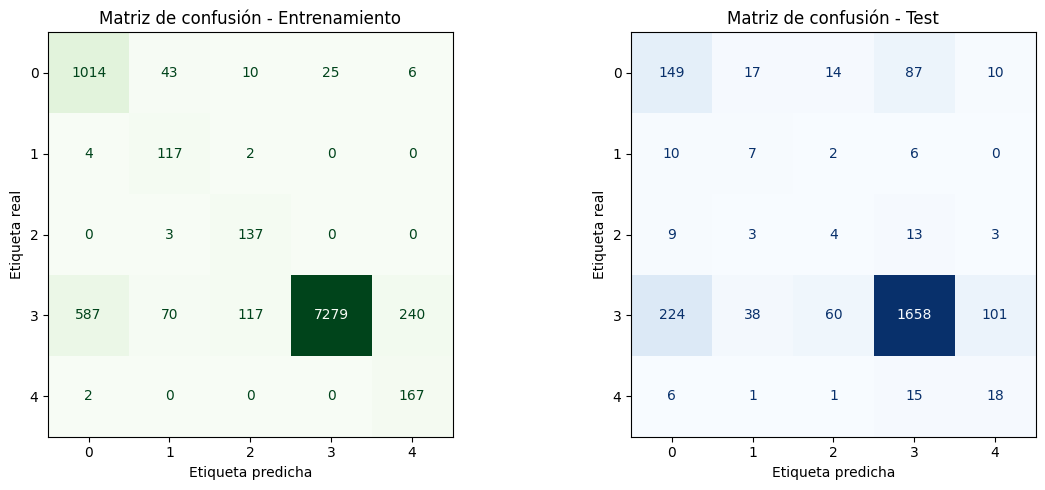

In [ ]:
# Predicciones sobre el conjunto de entrenamiento
y_train_pred_probs = model_refinado_3.predict(X_train)
y_train_pred = np.argmax(y_train_pred_probs, axis=1)

# Predicciones sobre el conjunto de prueba
y_test_pred_probs = model_refinado_3.predict(X_test)
y_test_pred = np.argmax(y_test_pred_probs, axis=1)

# Calculamos las matrices de confusión
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

# Visualizamos las matrices en paralelo
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Conjunto de entrenamiento
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=[0, 1, 2, 3, 4])
disp1.plot(ax=axes[0], cmap='Greens', colorbar=False)
axes[0].set_title("Matriz de confusión - Entrenamiento")
axes[0].set_xlabel("Etiqueta predicha")
axes[0].set_ylabel("Etiqueta real")

# Conjunto de prueba
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=[0, 1, 2, 3, 4])
disp2.plot(ax=axes[1], cmap='Blues', colorbar=False)
axes[1].set_title("Matriz de confusión - Test")
axes[1].set_xlabel("Etiqueta predicha")
axes[1].set_ylabel("Etiqueta real")

# Ajustamos presentación
plt.tight_layout()
plt.show()

Los resultados obtenidos en la sexta aproximación reflejan un comportamiento sólido tanto en entrenamiento como en validación. El modelo, entrenado con un vocabulario extendido a 5.000 tokens y regularización L1-L2 aplicada en la capa densa, alcanza una precisión del 93 % sobre el conjunto de entrenamiento y del 76 % sobre el conjunto de prueba. La evolución de las métricas muestra un aprendizaje progresivo y estable, sin señales claras de sobreajuste. La pérdida de validación alcanza su valor mínimo en la época 5 (0.80), momento a partir del cual se estabiliza sin incrementos pronunciados, lo que indica que el modelo ha conseguido un buen ajuste sin comprometer la generalización.

En la matriz de confusión del conjunto de entrenamiento, se observa un reconocimiento alto y preciso en todas las clases, incluida la clase mayoritaria. Las clases minoritarias son correctamente identificadas y presentan errores residuales dispersos, sin concentrarse de forma sistemática en una única categoría. En la matriz de prueba, el modelo mantiene un rendimiento estable, reconociendo correctamente 1.658 instancias de la clase 3 y logrando una mejora apreciable en el reconocimiento de la clase 2, que incrementa sus aciertos respecto a aproximaciones anteriores. Las clases 1 y 4 también mantienen un rendimiento constante, sin pérdida de capacidad de discriminación.

En comparación con el modelo anterior, entrenado con vocabulario reducido a 2.500 tokens, esta configuración logra una mayor cobertura semántica sin incrementar el sobreajuste. La introducción de regularización L1-L2 ha contribuido a controlar la complejidad del modelo, permitiendo aprovechar la riqueza del vocabulario ampliado sin penalizar la capacidad de generalización. El equilibrio alcanzado entre precisión global y sensibilidad hacia clases poco representadas convierte a esta sexta aproximación en la más robusta y fiable desarrollada hasta el momento.

## 5. Entrenamiento del modelo final

Una vez identificada la configuración más eficaz en la sexta aproximación, se procede a consolidarla como modelo final y realizar una evaluación exhaustiva de su comportamiento.

### 5.1 - Ajuste del vocabulario y la longitud de secuencia para mejorar la representación del texto

In [ ]:
# Definimos nuevos parámetros para la capa de vectorización
nuevo_vocabulario = 5000               # Aumentamos el número de tokens considerados (antes 1000)
longitud_secuencia = 120               # Aumentamos la longitud máxima de secuencia por mensaje

# Creamos una nueva capa TextVectorization con los nuevos parámetros
vectorizador_mejorado = tf.keras.layers.TextVectorization(
    max_tokens=nuevo_vocabulario,               # Número máximo de palabras consideradas
    output_mode='int',                          # Modo de salida: índices enteros
    output_sequence_length=longitud_secuencia   # Longitud fija de las secuencias
)

# Extraemos solo los textos del conjunto de entrenamiento (ya limpiados y divididos)
def extraer_texto(texto, etiqueta):
    return texto

# Adaptamos el vectorizador al texto del conjunto de entrenamiento
dataset_texto = train_dataset.map(extraer_texto)
vectorizador_mejorado.adapt(dataset_texto)

### 5.2 - Definición de la arquitectura del modelo RNN

In [ ]:
# Definimos el modelo con regularización mixta y Dropout moderado
final_model = tf.keras.Sequential([
    vectorizador_mejorado,  # Capa de entrada con vocabulario ajustado (2000 tokens)
    tf.keras.layers.Embedding(input_dim=nuevo_vocabulario,
                              output_dim=dimension_embedding,
                              mask_zero=True),

    # Capa BiLSTM
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),

    # Dropout ligero para reducir co-adaptación entre neuronas
    tf.keras.layers.Dropout(0.2),

    # Capa densa con regularización L1-L2
    tf.keras.layers.Dense(
        64,
        activation='relu',
        kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
    ),

    # Capa de salida
    tf.keras.layers.Dense(num_clases, activation='softmax')
])

### 5.3 - Compilación del modelo.

In [ ]:
# Compilamos el modelo
final_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

### 5.4 - Entrenamiento del modelo

In [ ]:
# Entrenamos el modelo aplicando los mismos pesos de clase que en la aproximación anterior
history_final_model = final_model.fit(
    train_dataset,
    epochs=30,
    validation_data=test_dataset,
    callbacks=[early_stop],
    class_weight=pesos_dict,
    verbose=1
)

Epoch 1/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.2527 - loss: 1.6054 - val_accuracy: 0.4536 - val_loss: 1.4832
Epoch 2/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6816 - loss: 1.2370 - val_accuracy: 0.6930 - val_loss: 0.8650
Epoch 3/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7829 - loss: 0.7076 - val_accuracy: 0.7044 - val_loss: 0.8196
Epoch 4/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8530 - loss: 0.3716 - val_accuracy: 0.7199 - val_loss: 0.8363
Epoch 5/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8884 - loss: 0.2043 - val_accuracy: 0.7313 - val_loss: 0.8573
Epoch 6/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9061 - loss: 0.1544 - val_accuracy: 0.7675 - val_loss: 0.8620
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.


### 5.5 - Evaluación del modelo final

### 5.4.1 - Visualización tabular de métricas por época

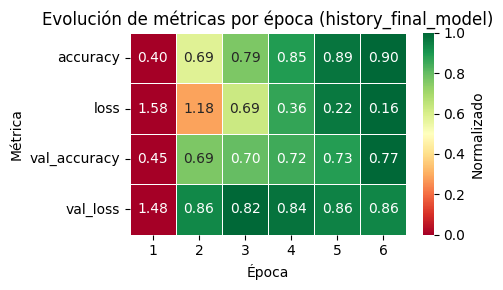

In [ ]:
# Convertimos el historial en DataFrame
history_final_model_df = pd.DataFrame(history_final_model.history)
history_final_model_df["epoch"] = history_final_model_df.index + 1  # Añadimos número de época

# Normalizamos las columnas para visualización con inversión en loss
normalized_df = history_final_model_df.copy()
for col in history_final_model_df.columns:
    if col != "epoch":
        max_val = history_final_model_df[col].max()
        min_val = history_final_model_df[col].min()
        if 'loss' in col:
            # Invertimos la escala para que valores bajos sean verdes
            normalized_df[col] = 1 - (history_final_model_df[col] - min_val) / (max_val - min_val)
        else:
            # Escala normal para accuracy
            normalized_df[col] = (history_final_model_df[col] - min_val) / (max_val - min_val)

# Dibujamos el mapa de calor con colores corregidos
plt.figure(figsize=(5, 3))
sns.heatmap(
    normalized_df.set_index("epoch").T,
    cmap="RdYlGn",
    annot=history_final_model_df.set_index("epoch").T,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={'label': 'Normalizado'}
)
plt.title("Evolución de métricas por época (history_final_model)")
plt.xlabel("Época")
plt.ylabel("Métrica")
plt.tight_layout()
plt.show()

En la visualización de métricas por época correspondiente al modelo final, se observa un patrón de aprendizaje progresivo y coherente. La precisión en entrenamiento (`accuracy`) mejora de forma estable desde un valor inicial del 40 % hasta alcanzar un 90 % en la última época. La pérdida (`loss`) desciende de forma paralela, indicando una convergencia efectiva del modelo, reduciéndose de 1.58 a 0.16.

En validación, se alcanza una `val_accuracy` máxima de 0.77 en la época 6, aunque la pérdida de validación (`val_loss`) muestra un comportamiento ligeramente plano a partir de la época 3, momento en el que se detecta el mejor equilibrio entre generalización y ajuste. Por este motivo, el mecanismo de parada temprana (`EarlyStopping`) restaura los pesos correspondientes a la época 3, lo que indica que, aunque el entrenamiento posterior mejora métricas internas, la capacidad de generalización empieza a estabilizarse.

Este comportamiento refleja una fase de entrenamiento controlada, sin sobreajuste evidente, y con una validación sólida que alcanza niveles superiores a los obtenidos en muchas de las aproximaciones previas. La curva de métricas respalda la decisión de conservar los pesos del modelo correspondientes a la época 3 como la versión final óptima.

### 5.4.2 - Matrices de confusión del modelo (entrenamiento vs prueba)

307/307 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


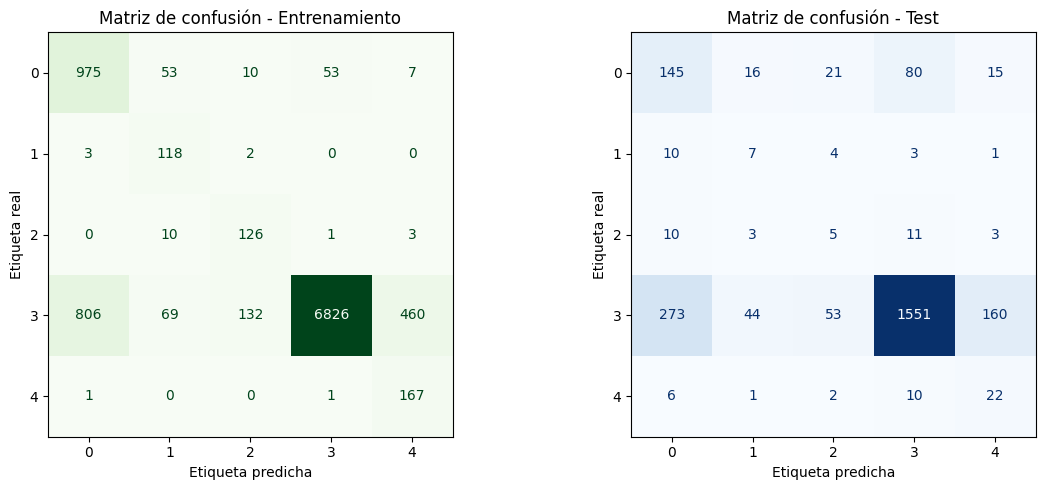

In [ ]:
# Predicciones sobre el conjunto de entrenamiento
y_train_pred_probs = final_model.predict(X_train)
y_train_pred = np.argmax(y_train_pred_probs, axis=1)

# Predicciones sobre el conjunto de prueba
y_test_pred_probs = final_model.predict(X_test)
y_test_pred = np.argmax(y_test_pred_probs, axis=1)

# Calculamos las matrices de confusión
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

# Visualizamos las matrices en paralelo
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Conjunto de entrenamiento
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=[0, 1, 2, 3, 4])
disp1.plot(ax=axes[0], cmap='Greens', colorbar=False)
axes[0].set_title("Matriz de confusión - Entrenamiento")
axes[0].set_xlabel("Etiqueta predicha")
axes[0].set_ylabel("Etiqueta real")

# Conjunto de prueba
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=[0, 1, 2, 3, 4])
disp2.plot(ax=axes[1], cmap='Blues', colorbar=False)
axes[1].set_title("Matriz de confusión - Test")
axes[1].set_xlabel("Etiqueta predicha")
axes[1].set_ylabel("Etiqueta real")

# Ajustamos presentación
plt.tight_layout()
plt.show()

En la matriz de entrenamiento, el modelo presenta una buena capacidad de clasificación general. La clase 3, que es la más representada, concentra la mayoría de los aciertos con 6.826 clasificaciones correctas, aunque también se observan errores relevantes hacia las clases 0 y 4, con 806 y 460 desviaciones respectivamente. Las clases minoritarias, como la 0, 1 y 2, son clasificadas con niveles aceptables de precisión, destacando los 975 aciertos en la clase 0 y los 118 en la clase 1. La clase 2 muestra cierta dispersión hacia la clase 1 y especialmente hacia la clase 4.

En la matriz de test, el modelo mantiene una estructura de comportamiento similar, aunque con mayor dispersión. La clase 3 continúa siendo reconocida con solidez (1.551 aciertos), pero aumenta el número de errores hacia las clases vecinas, en particular hacia la clase 0 (273) y la clase 4 (160). Las clases 0, 1 y 2 muestran un desempeño moderado: la clase 0 conserva 145 aciertos, pero con 80 errores hacia la clase 3; la clase 1 obtiene 7 aciertos y presenta dispersión hacia otras categorías; la clase 2 logra 5 aciertos y evidencia dificultad en su diferenciación. La clase 4 alcanza 22 aciertos, superando ligeramente las cifras observadas en algunas aproximaciones previas.

El patrón global confirma que el modelo ha aprendido a clasificar correctamente la clase dominante y ha conservado parte de la sensibilidad hacia las clases minoritarias, aunque la dispersión en test revela cierta dificultad para generalizar con precisión en estas categorías menos representadas.

### 5.4.3 - Análisis de precisión y *recall* desglosado por clase

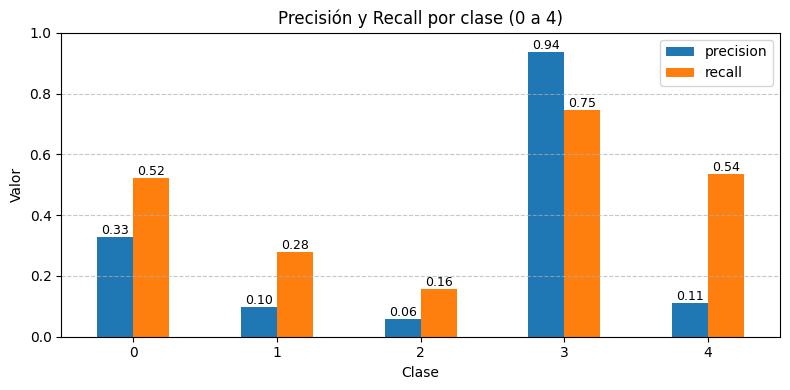

In [ ]:
# Calculamos el informe de clasificación (precisión, recall, f1-score por clase)
report_dict = classification_report(y_test, y_test_pred, output_dict=True)

# Convertimos el informe en un DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Seleccionamos solo las clases (ignoramos 'accuracy', 'macro avg', 'weighted avg')
clases_df = report_df.iloc[:5][['precision', 'recall']]

# Creamos la figura y el eje
fig, ax = plt.subplots(figsize=(8, 4))

# Dibujamos el gráfico de barras
clases_df.plot(kind='bar', ax=ax)

# Título y ejes
plt.title('Precisión y Recall por clase (0 a 4)')
plt.xlabel('Clase')
plt.ylabel('Valor')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Añadimos el valor encima de cada barra
for p in ax.patches:
    valor = f"{p.get_height():.2f}"
    ax.annotate(valor,
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

El gráfico de barras muestra un análisis desglosado de precisión y *recall* por clase en el conjunto de prueba. Como era de esperar, la clase 3 alcanza los mejores resultados, con una precisión del 94 % y un *recall* del 75 %, lo que indica que el modelo acierta en la gran mayoría de las predicciones y es capaz de recuperar correctamente una proporción alta de ejemplos reales de esta clase.

En cambio, el rendimiento en las clases minoritarias es considerablemente más bajo. La clase 0 presenta un *recall* aceptable (0.52), pero con una precisión baja (0.33), lo que sugiere que, aunque el modelo detecta más de la mitad de los ejemplos reales de clase 0, también comete bastantes errores al predecir esta etiqueta en ejemplos que no le corresponden. Las clases 1 y 2 muestran niveles muy bajos en ambas métricas, especialmente en precisión (0.10 y 0.06 respectivamente), lo que revela que el modelo tiene dificultades importantes para diferenciarlas del resto. En particular, la clase 2 combina una precisión extremadamente baja con un *recall* de apenas 0.16, reflejando una pobre capacidad de identificación. La clase 4 presenta un caso algo distinto: su precisión es baja (0.11), pero su *recall* es más aceptable (0.54), lo que indica que el modelo tiende a sobrepredecir esta clase, asignándola incorrectamente a instancias de otras categorías.

Este análisis confirma que el modelo está claramente condicionado por el desbalance de clases: obtiene buenos resultados en la clase dominante, pero sufre limitaciones importantes en la detección y precisión de las clases minoritarias. La diferencia entre *precision* y *recall* en estas clases sugiere además comportamientos distintos: en unas hay omisión, en otras confusión sistemática.

### 5.4.4 - Representación del *F1-score* y soporte por clase mediante barras

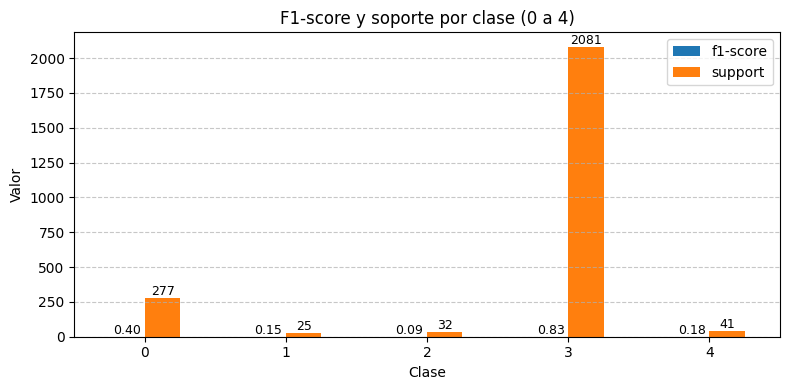

In [ ]:
# Extraemos F1-score y soporte por clase (0 a 4)
f1_support_df = report_df.iloc[:5][['f1-score', 'support']]

# Creamos la figura y el eje
fig, ax = plt.subplots(figsize=(8, 4))

# Dibujamos el gráfico de barras
f1_support_df.plot(kind='bar', ax=ax)

# Título y ejes
plt.title('F1-score y soporte por clase (0 a 4)')
plt.xlabel('Clase')
plt.ylabel('Valor')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Añadimos el valor encima de cada barra
for p in ax.patches:
    valor = f"{p.get_height():.2f}" if p.get_height() <= 1 else f"{int(p.get_height())}"
    ax.annotate(valor,
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

El gráfico muestra la relación entre el *F1-score* y el soporte (número de ejemplos reales) para cada clase en el conjunto de prueba. Tal como se observa, la clase 3, con un soporte de 2.081 instancias, presenta el mejor *F1-score* con un valor de 0.83, lo que confirma que el modelo ha aprendido correctamente los patrones de la clase mayoritaria, tanto en precisión como en cobertura.

Sin embargo, en las clases menos representadas el comportamiento se degrada de forma notable. Las clases 1, 2 y 4 presentan *F1-scores* inferiores a 0.20, lo que implica que el equilibrio entre precisión y *recall* en estas categorías es muy pobre. Esto se ve especialmente en la clase 2, que con un soporte de 32 casos apenas alcanza un *F1-score* de 0.09. La clase 1, con solo 25 ejemplos, también queda muy por debajo del umbral mínimo para considerar su detección efectiva. La clase 0, pese a contar con un soporte mucho mayor (277), obtiene un *F1-score* de 0.40, lo que sugiere que aunque el modelo tiene cierta capacidad para reconocerla, su rendimiento sigue siendo limitado.

Este análisis confirma que el rendimiento del modelo está fuertemente condicionado por la distribución de clases. A pesar de aplicar `class_weight` y regularización, la brecha entre clases con alto y bajo soporte sigue siendo evidente. Las métricas agregadas ocultan esta desigualdad, por lo que esta visualización es clave para valorar la efectividad real del modelo en un escenario desbalanceado.

### 5.4.5 - Curvas ROC en clasificación multiclase mediante esquema *one-vs-rest*

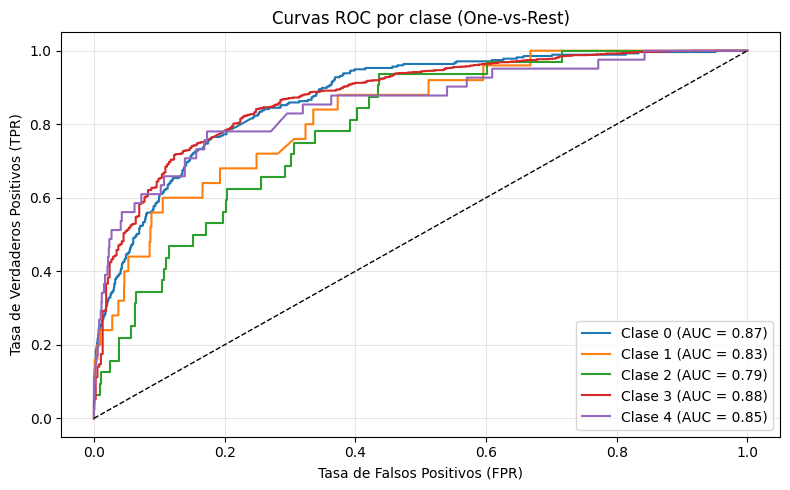

In [ ]:
# Binarizamos las etiquetas verdaderas
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4])
n_clases = y_test_bin.shape[1]

# Vectorizamos el texto con TF-IDF para usarlo en un clasificador base
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Clasificador base: Regresión logística en esquema One-vs-Rest
modelo_ovr = OneVsRestClassifier(LogisticRegression(solver='liblinear'))
modelo_ovr.fit(X_train_tfidf, label_binarize(y_train, classes=[0, 1, 2, 3, 4]))

# Predicciones de probabilidad para cada clase
y_score = modelo_ovr.predict_proba(X_test_tfidf)

# Calculamos las curvas ROC y el AUC por clase
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_clases):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Dibujamos todas las curvas ROC
plt.figure(figsize=(8, 5))
for i in range(n_clases):
    plt.plot(fpr[i], tpr[i],
             label=f'Clase {i} (AUC = {roc_auc[i]:.2f})')

# Diagonal aleatoria
plt.plot([0, 1], [0, 1], 'k--', lw=1)

# Configuración de la gráfica
plt.title('Curvas ROC por clase (One-vs-Rest)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

El gráfico presenta las curvas ROC para cada clase en un esquema de clasificación multiclase *one-vs-rest*, junto con el área bajo la curva (AUC) correspondiente a cada una. Todas las curvas se sitúan por encima de la diagonal aleatoria, lo que confirma que el modelo tiene capacidad de discriminación para todas las clases.

La clase 3, como es habitual en este modelo, presenta uno de los mejores desempeños, con un AUC de 0.88, reflejando su clara ventaja por representar la mayoría de los ejemplos del conjunto de entrenamiento. Sorprendentemente, la clase 0 alcanza el AUC más alto (0.87), lo que indica que, aunque sus métricas de precisión eran limitadas, el modelo sí logra distinguirla de forma efectiva frente al resto cuando se analiza desde una perspectiva probabilística.

Las clases 1 y 2, a pesar de su bajo soporte y F1-score, logran AUCs respetables de 0.83 y 0.79 respectivamente. Esto sugiere que el modelo es capaz de asignar puntuaciones de probabilidad razonables a estas clases, aunque su umbral de decisión no sea óptimo. En otras palabras, podría estar capturando información útil pero clasificando mal por una decisión binaria ajustada al punto de corte estándar.

Finalmente, la clase 4 alcanza un AUC de 0.85, en línea con el comportamiento observado en otras métricas. Las curvas ROC revelan que incluso las clases con bajo rendimiento absoluto tienen cierto grado de separabilidad, lo cual puede ser aprovechado mediante técnicas posteriores de ajuste de umbrales o calibración.

### 5.4.6 - Distribución de errores de clasificación según clase verdadera

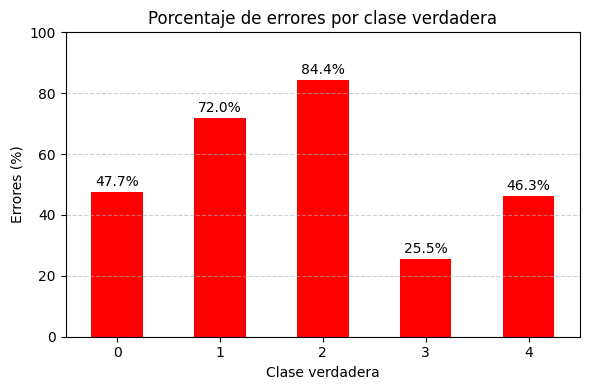

In [ ]:
# Creamos una máscara para filtrar las predicciones incorrectas
errores = y_test != y_test_pred

# Total de ejemplos reales por clase
total_por_clase = pd.Series(y_test).value_counts().sort_index()

# Número de errores por clase verdadera
errores_por_clase = pd.Series(y_test[errores]).value_counts().sort_index()

# Calculamos el porcentaje de error por clase
porcentaje_errores = (errores_por_clase / total_por_clase * 100).fillna(0)

# Representamos el porcentaje de errores por clase verdadera
plt.figure(figsize=(6, 4))
porcentaje_errores.plot(kind='bar', color='red')

# Añadimos los porcentajes encima de cada barra
for i, valor in enumerate(porcentaje_errores):
    plt.text(i, valor + 1, f"{valor:.1f}%", ha='center', va='bottom', fontsize=10)

# Configuración del gráfico
plt.title("Porcentaje de errores por clase verdadera")
plt.xlabel("Clase verdadera")
plt.ylabel("Errores (%)")
plt.ylim(0, 100)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

El gráfico muestra el porcentaje de errores cometidos por el modelo en función de la clase verdadera. Esta visualización permite interpretar los errores de forma proporcional al número total de muestras por clase, lo que evita caer en interpretaciones sesgadas por el tamaño de cada grupo.

La clase 2 destaca como la más problemática, con un 84.4 % de errores, lo que implica que el modelo apenas logra identificarla correctamente. Le siguen la clase 1 con un 72.0 % y la clase 0 con un 47.7 %, evidenciando también un comportamiento débil en estas categorías. En contraste, la clase 3 —la más frecuente— presenta el menor porcentaje de error, con solo un 25.5 %, lo que confirma que el modelo tiene una mayor capacidad de generalización para ella. La clase 4 muestra un comportamiento intermedio, con un 46.3 % de errores, lo que si bien es elevado, representa un mejor rendimiento proporcional que el observado en clases como la 1 o la 2.

Este análisis confirma que el desbalance de clases afecta no solo al volumen de aciertos absolutos, sino también al porcentaje de error relativo, con un impacto mayor en las clases con menor representatividad.

### 5.4.6 - Comparación directa entre etiquetas reales y predicciones en test

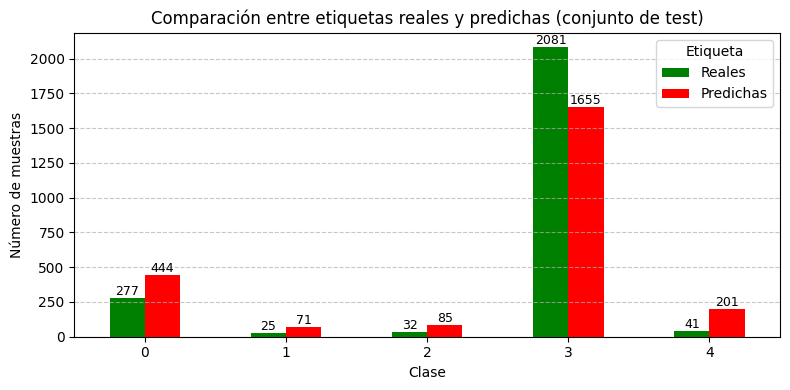

In [ ]:
# Creamos un DataFrame con etiquetas reales y predichas
comparacion_df = pd.DataFrame({
    'Real': y_test,
    'Predicha': y_test_pred
})

# Contamos las frecuencias de etiquetas reales y predichas
conteo_real = comparacion_df['Real'].value_counts().sort_index()
conteo_predicha = comparacion_df['Predicha'].value_counts().sort_index()

# Unificamos en un único DataFrame para comparar visualmente
conteo_comparado = pd.DataFrame({
    'Reales': conteo_real,
    'Predichas': conteo_predicha
}).fillna(0)

# Representamos las frecuencias mediante un gráfico de barras agrupadas
ax = conteo_comparado.plot(kind='bar', figsize=(8, 4), color=['green', 'red'])

# Añadimos etiquetas con los valores encima de cada barra
for p in ax.patches:
    altura = p.get_height()
    if altura > 0:
        ax.annotate(f'{int(altura)}',
                    (p.get_x() + p.get_width() / 2, altura),
                    ha='center', va='bottom', fontsize=9)

# Configuración del gráfico
plt.title("Comparación entre etiquetas reales y predichas (conjunto de test)")
plt.xlabel("Clase")
plt.ylabel("Número de muestras")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="Etiqueta")
plt.tight_layout()
plt.show()

El gráfico compara directamente el número de muestras por clase entre las etiquetas reales y las predichas por el modelo en el conjunto de test. Esta representación permite identificar de forma visual y precisa los desajustes entre la distribución original y la generada por el modelo.

Se observa que en la clase 3, la más representada, el modelo tiende a subestimar ligeramente su frecuencia real: se parte de 2.081 ejemplos reales, pero solo se predicen 1.655. Este desfase sugiere que el modelo está reasignando parte de esas instancias a otras clases, posiblemente como resultado de la penalización introducida por la ponderación de clases o la regularización.

En cambio, en las clases 0, 1, 2 y 4 ocurre el fenómeno contrario, el modelo sobrerrepresenta sus predicciones. Por ejemplo, la clase 0 tiene 277 casos reales, pero es asignada 444 veces; la clase 2, con 32 ejemplos reales, es predicha en 85 ocasiones. Esto indica una tendencia del modelo a sobreetiquetar instancias como pertenecientes a estas clases, lo que podría estar compensando su baja frecuencia real, pero también revela un nivel significativo de confusión.

En este caso, los errores se concentran en torno a un intento de equilibrar las clases poco representadas, generando sobredetección en unas y pérdida de sensibilidad en otras.

## 5.6 - Análisis final

El análisis global del modelo entrenado revela un rendimiento desigual condicionado por el desbalance del conjunto de datos. Las métricas globales muestran una evolución coherente durante el entrenamiento, con una `val_accuracy` que alcanza un 77 % y una pérdida controlada gracias al uso de regularización y ponderación de clases. El modelo ha logrado un buen ajuste en la clase mayoritaria (clase 3), obteniendo un *F1-score* de 0.83 y un AUC de 0.88, lo que indica una alta capacidad de discriminación y generalización en esa categoría.

Sin embargo, el rendimiento sobre las clases minoritarias ha sido claramente inferior. Las clases 1 y 2 presentan valores de precisión, *recall* y *F1-score* muy bajos, con tasas de error superiores al 70 %. Aunque la clase 4 mejora ligeramente en *recall* y AUC, el modelo tiende a sobrerrepresentarla en las predicciones, como ocurre también con las clases 0 y 2. Las gráficas de errores por clase y la comparación entre etiquetas reales y predichas evidencian esta distribución desequilibrada en el comportamiento del modelo.

Puede afirmarse que el modelo ha captado adecuadamente los patrones de la clase dominante y ha desarrollado cierta sensibilidad hacia las clases minoritarias, pero sin alcanzar un rendimiento satisfactorio en ellas. La estrategia seguida ha permitido mantener controlado el sobreajuste, pero no ha sido suficiente para garantizar una clasificación robusta y equitativa en todo el rango de clases.

Aunque existen múltiples líneas de mejora posibles, como el ajuste de umbrales por clase, técnicas de *data augmentation* textual, modelos más complejos o estrategias específicas de aprendizaje focalizado, estas no han sido implementadas en esta práctica por limitaciones de tiempo.

## 6. Conclusiones

A lo largo de esta actividad se ha desarrollado, ajustado y evaluado un modelo de red neuronal recurrente con arquitectura BiLSTM para la clasificación de mensajes según su nivel de odio. El principal desafío ha sido el desequilibrio entre clases, con una clara predominancia de la clase 3. Para hacer frente a este problema, se han explorado múltiples aproximaciones: desde la modificación del vocabulario y la longitud de secuencia hasta la incorporación de técnicas de regularización y ponderación de clases mediante `class_weight`.

Se han evaluado distintos modelos con representación ampliada y reducida del texto, y se ha determinado que la configuración más equilibrada corresponde a la sexta aproximación, que combina un vocabulario extenso con regularización L1-L2. Esta versión ha ofrecido un buen rendimiento sobre la clase mayoritaria y cierta sensibilidad hacia las minoritarias, manteniendo bajo control el sobreajuste.

A través de múltiples visualizaciones, incluyendo mapas de calor, métricas por clase, curvas ROC y distribución de errores, se ha podido comprobar que, aunque el modelo alcanza una capacidad aceptable de generalización, su rendimiento sigue siendo limitado en las clases con menor representación. Aun así, la metodología seguida ha permitido identificar con claridad los puntos fuertes y débiles del modelo actual y sentar una base sólida para futuras mejoras.

## 7. Líneas futuras

Existen diversas estrategias que podrían aplicarse para mejorar el rendimiento del modelo, especialmente en la clasificación de clases minoritarias. Algunas de las más relevantes son:

1. **Ajuste de umbrales por clase:** adaptar el punto de decisión de la función `softmax` para cada clase según su distribución.
2. **Data augmentation textual:** aplicar técnicas de generación sintética de texto como traducción inversa, sinónimos o modelos de lenguaje generativos para aumentar la presencia de clases minoritarias.
3. **Focal loss o pérdida ponderada por error:** utilizar funciones de pérdida que penalicen más los errores en clases poco representadas.
4. **Reentrenamiento con reponderación dinámica:** aplicar esquemas de reentrenamiento que ajusten los pesos de clase en función del comportamiento observado en validación.